In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MeCab
import re
import collections
import random
from scipy.special import gamma, digamma, gammaln
from scipy.stats import dirichlet, multinomial
from IPython.core.pylabtools import figsize
%matplotlib inline

# MLP本 「トピックモデル」の実装＋実験＋式導出

「トピックモデル」本の中で紹介されている
* 最尤推定
* 変分ベイズ
* 崩壊型ギブスサンプリング
* 階層ディリクレ過程

の実装, 実験, 式の導出がしてあります.
使用データはwikipediaのデータです.

In [0]:
#wikipediaのデータから単語を抜き出す前処理処理

reg = r'".+"' 
reg_id = r'id=".*?"' # .*? は0個以上の任意の文字の最小一致という意味
reg_title = r'title=".*?"'
search_num = r"\d+"

pattern = re.compile(reg) #事前にコンパイルしておくと動作が早くなる
p1 = re.compile(reg_id)
p2 = re.compile(reg_title)
p3 = re.compile(search_num)

def to_id_title(words):
    ids = p1.search(words).group() #id=" "の部分を抜き出し
    title = p2.search(words).group() #title=" "の部分を抜き出し
    ids = pattern.search(ids).group()[1:-1] #id=" "から" "の中身を抜き出し
    title = pattern.search(title).group()[1:-1] #title=" "から" "の中身を抜き出し
    return (ids, title)

def to_wordlist(words):
    m = MeCab.Tagger ("-Ochasen")
    word_list = [] #抜き出した名詞リスト

    #不要語リスト
    remove_words = ["(", ")", "（", "）", "[", "]",
                    "「", "」", "+", "-", "*", "$",
                    "'", '"', "、", ".", "”", "’",
                    ":", ";", "_", "/", "?", "？", 
                    "!", "！", "。", ",", "%", "％",
                    "=", "＝", "&", "・"]
    
    with open("stop_word.txt", "r", encoding="utf-8") as f:
        stop_words = f.read().split() #ストップワード
    
    remove_words += stop_words
    remove_words += [n for n in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"]
    remove_words = set(remove_words)
    
    #分かち書きして分割された語を順にループ
    for chunk in m.parse(words.rstrip()).splitlines()[:-1]:
        word = chunk.rstrip().split('\t')[2] #分かち書きされた語
        tok = chunk.rstrip().split('\t')[3] #上の語の品詞

        #もしtokが名詞かつ不要語や数字が含まれていなかったらhukugouに追加
        if tok.startswith("名詞"):
            if not word in remove_words and re.search(p3, word) is None:
                word_list.append(word)
            
    return word_list

def make_kizi(word_num):
    kizi_dict = {} #{title: [words]}
    all_word = [] #使用する記事に出てくる全単語
    with open("wiki100.txt", "r") as files:
        string = files.readline()
        kizi = title = ids = ""
        i = 0
        
        while string:
            if string.find('<doc') >= 0:
                ids, title = to_id_title(string)
            elif string.find('</doc>') >= 0:
                tmp = to_wordlist(kizi)
                if 300 < len(tmp) < 600: #適当な長さの記事を使用
                    print(i) #確認用
                    kizi_dict[title] = tmp
                    all_word += tmp
                kizi = ""
                print('number:%d title:%s id:%s' %(i, title, ids)) #確認用python2ならかっこを外してください。
                i += 1
            else:
                kizi = kizi + string.strip()
            
            string = files.readline()
    
    c = collections.Counter(all_word).most_common()
    word_list = [c[i][0] for i in range(word_num)]
    word_set = set(word_list)
    new_kizi_dict = {}
    
    for title, words in kizi_dict.items():
        tmp = [w for w in words if w in word_set]
        new_kizi_dict[title] = tmp
        
    return new_kizi_dict, word_list


#最尤推定
"""
word_dict : dict {title:[words]}
all_word : list
topic_num : トピック数
iteration : ループ数
"""
def plsa(word_dict, all_word, topic_num, iteration=300):
    word_num = len(all_word)
    theta = np.random.dirichlet(np.random.rand(topic_num)+1., len(word_dict)) #(記事数, トピック数)
    phi = np.random.dirichlet(np.random.rand(word_num)+1., topic_num) #(トピック数, 単語数)
    for i in range(iteration):
        print("i:%d" %i)
        theta_next = np.zeros(theta.shape)
        phi_next = np.zeros(phi.shape)
        L = 0
        for d, words in enumerate(word_dict.values()):
            for n in words:
                #_L = 0
                q = theta[d]*phi[:, all_word.index(n)]/np.dot(theta[d], phi[:,all_word.index(n)])
                theta_next[d] += q
                phi_next[:, all_word.index(n)] += q
                L += np.log(np.dot(theta[d], phi[:, all_word.index(n)]))
        theta = theta_next.copy()
        phi = phi_next.copy()
        theta /= theta.sum(axis=1).reshape(theta.shape[0],1)
        phi /= phi.sum(axis=1).reshape(phi.shape[0],1)
        print("likelihood:%d" %L)
    return theta, phi


#変分ベイズ
"""
word_dict : dict {title:[words]}
all_word : list
topic_num : トピック数
iteration : ループ数
"""
def vbe(word_dict, all_word, topic_num, iteration=300):
    word_num = len(all_word)
    alpha = np.random.rand(len(word_dict), topic_num)+1.0 #(記事数, トピック数)
    beta = np.random.rand(topic_num, word_num)+1.0 #(トピック数, 単語数)
    beta_next = beta.copy()
    theta = np.random.dirichlet(np.random.rand(topic_num)+1.0, len(word_dict)) #(記事数, トピック数)
    phi = np.random.dirichlet(np.random.rand(word_num)+1.0, topic_num) #(トピック数, 単語数)
    for i in range(iteration):
        print("i:%d" %i)
        q = digamma(alpha) - digamma(alpha.sum(axis=1)).reshape(alpha.shape[0],1) - \
            digamma(beta.sum(axis=1))
        L = 0
        for d, words in enumerate(word_dict.values()):
            for n in words:
                ind = all_word.index(n)
                q_ = np.exp(q[d] + digamma(beta[:, ind]))
                q_ /= q_.sum()
                alpha[d] += q_
                beta_next[:, ind] += q_
                L += np.log(np.dot(theta[d], phi[:, ind]))
            
        print("likelihood:%d" %L)
        #print(beta[0])
        beta = beta_next.copy()
        for j in range(theta.shape[0]):
            theta[j] = dirichlet.rvs(alpha[j], 1)
        for m in range(phi.shape[0]):
            phi[m] = dirichlet.rvs(beta[m], 1)
            
    #return alpha, beta
    return theta, phi


#崩壊型ギブスサンプリング
"""
word_dict : dict {title:[words]}
all_word : list
topic_num : トピック数
iteration : ループ数
"""
def gibbs(word_dict, all_word, topic_num, iteration=300):
    word_num = len(all_word)
    dict_len = len(word_dict)
    alpha = np.random.rand(topic_num)+1.0 #(トピック数)
    beta = 1. 
    N_dk = np.zeros((dict_len, topic_num), dtype=np.int) #文書dでトピックkが割り当てられた単語数
    N_kv = np.zeros((topic_num, word_num), dtype=np.int) #文書全体でトピックkが割り当てられた単語vの数
    N_k = np.zeros(topic_num, dtype=np.int) #文書全体でトピックkが割り当てられた回数
    N_d = np.zeros(dict_len, dtype=np.int) #文書dの単語数
    z_dn = [] #文書dのn番目の単語に割り当てられたトピック
    for i in range(iteration):
        print("i:%d" %i)
        for d, words in enumerate(word_dict.values()):
            if i == 0:
                N_d[d] = len(words)
                z_dn.append([None for j in range(len(words))])
            for j, n in enumerate(words):
                ind = all_word.index(n)
                if i > 0:
                    N_dk[d][z_dn[d][j]] -= 1
                    N_kv[z_dn[d][j]][ind] -= 1
                    N_k[z_dn[d][j]] -= 1
                p = (N_dk[d] + alpha)*((N_kv[:, ind] + beta)/(N_k[:] + beta*word_num))
                p /= p.sum()
                z = int(np.where(multinomial.rvs(1, p) == 1)[0])
                z_dn[d][j] = z
                N_dk[d][z] += 1
                N_kv[z][ind] += 1
                N_k[z] += 1
                
        alpha *= (digamma(N_dk + alpha).sum(axis=0) - dict_len*digamma(alpha)) / \
                 (digamma(N_d + alpha.sum()).sum() - dict_len*digamma(alpha.sum()))
        beta  *= (digamma(N_kv + beta).sum() - topic_num*word_num*digamma(beta)) / \
                 (word_num*digamma(N_k + beta*word_num).sum() - topic_num*word_num*digamma(beta*word_num))
        
        L = dict_len*(gammaln(alpha.sum()) - gammaln(alpha).sum()) + \
            gammaln(N_dk + alpha).sum() - gammaln(N_d + alpha.sum()).sum() + \
            topic_num*(gammaln(beta*word_num) - word_num*gammaln(beta)) + \
            gammaln(N_kv + beta).sum() - gammaln(N_k + beta*word_num).sum()
            
        print("likelihood:%d" %L)
        
    theta = (N_dk + alpha) / np.c_[(N_d + alpha.sum())]
    phi = (N_kv + beta) / np.c_[(N_k + beta*word_num)]
    
    return theta, phi


#階層ディリクレ過程
"""
word_dict : dict {title:[words]}
all_word : list
topic_num : トピック数
alpha, gamma, beta : ハイパーパラメータ
iteration : ループ数
"""
def HDP_LDA(word_dict, all_word, alpha=1.0, gamma=1.0, beta=1.0, iteration=300):
    word_dict, test_dict = make_tastdata(word_dict)
    dict_len = len(word_dict) 
    word_num = len(all_word)
    N_dk = np.empty((dict_len, 0), dtype=np.int) #文書dでトピックkが割り当てられた単語数
    N_kv = np.empty((0, word_num), dtype=np.int) #文書全体でトピックkが割り当てられた単語vの数
    N_k = np.empty(0, dtype=np.int) #文書全体でトピックkが割り当てられた回数
    N_d = np.zeros(dict_len, dtype=np.int) #文書dの単語数
    N_dlv = [np.empty((0, word_num), dtype=np.int) for i in range(dict_len)]#文書dでL番目のテーブルに割り当てられた単語vの数
    t_dn = [] #文書dのn番目の単語に割り当てられたテーブル
    z_dl = [[] for j in range(dict_len)] #文書dのL番目のテーブルに割り当てられたトピック
    z_dn = [] #文書dのn番目の単語に割り当てられたトピック
    M_k = np.empty(0, dtype=np.int) #トピックkを選んだテーブル数
    #N_dl = None #文書dでL番目のテーブルを選んだ単語数(N_dlvで兼用できる)
    #M = None #テーブル数(M_kで兼用できる)
    L_list = []
    perp_list = []
    topicnum_list = []
    tablenum_list = []
    
    for i in range(iteration):
        print("i:%d" %i)
        for d, words in enumerate(word_dict.values()):
            if d % 500 == 0:
                print("d:%d" %d)
            if i == 0:
                N_d[d] = len(words)
                tmp = [-1 for j in range(N_d[d])]
                z_dn.append(np.array(tmp, dtype=np.int))
                t_dn.append(np.array(tmp, dtype=np.int))
        
            for j, n in enumerate(words): 
                ind = all_word.index(n)
                if i > 0:
                    N_dk[d][z_dn[d][j]] -= 1
                    N_kv[z_dn[d][j]][ind] -= 1
                    N_k[z_dn[d][j]] -= 1
                    N_dlv[d][t_dn[d][j]][ind] -= 1
                    if N_dlv[d][t_dn[d][j]].sum() == 0: #文書dでテーブルLに座る人がいなくなったら
                        N_dlv[d] = np.delete(N_dlv[d], t_dn[d][j], axis=0)
                        M_k[z_dn[d][j]] -= 1
                        del z_dl[d][t_dn[d][j]]
                        t_dn[d][t_dn[d] > t_dn[d][j]] -= 1 #インデックスずらし
                        if N_k[z_dn[d][j]] == 0:
                            #文書dでテーブルLに座る人がいなくなった事によってトピックkの割り当てが0になったら
                            #print("a")
                            N_dk = np.delete(N_dk, z_dn[d][j], axis=1)
                            N_kv = np.delete(N_kv, z_dn[d][j], axis=0)
                            N_k = np.delete(N_k, z_dn[d][j])
                            M_k = np.delete(M_k, z_dn[d][j]) 
                            for x in z_dn:#インデックスずらし
                                x[x > z_dn[d][j]] -= 1
                            for xn, x in enumerate(z_dl):#インデックスずらし
                                z_dl[xn] = [y-1 if y>z_dn[d][j] else y for y in x]

                exist_t = np.array([])
                exist_t_len = 0
                new_t_E = np.array([]) 
                new_t_E_len = 0 
                if i != 0 or d != 0 or j != 0 :
                    new_t_E = (alpha*M_k/(M_k.sum()+gamma))*(N_kv[:, ind] + beta)/(N_k + beta*word_num)
                    new_t_E_len = len(new_t_E)
                    if i != 0 or j != 0 :
                        exist_t = N_dlv[d].sum(axis=1)*(N_kv[:, ind][z_dl[d]] + beta)/(N_k[z_dl[d]] + beta*word_num)
                        exist_t_len = len(exist_t)
                new_t_N = alpha*(gamma/(M_k.sum()+gamma))/word_num
                p_td = np.hstack((exist_t, new_t_E, new_t_N))
                p_td_len = len(p_td)
                #p_td = p_td.astype(float)
                p_td = p_td / p_td.sum() #- 0.00001/p_td.size
                z = int(np.where(multinomial.rvs(1, p_td) == 1)[0])
                if z == p_td_len-1: #新テーブル新トピック   
                    N_dk = np.append(N_dk, np.zeros((dict_len, 1), dtype=np.int) ,axis=1)
                    N_kv = np.append(N_kv, np.zeros((1, word_num), dtype=np.int), axis=0)
                    N_dlv[d] = np.append(N_dlv[d], np.zeros((1, word_num), dtype=np.int), axis=0)
                    N_k = np.append(N_k, 1)
                    M_k = np.append(M_k, 1)
                    new_topic = len(M_k)-1 
                    N_dk[d][new_topic] = 1
                    N_kv[new_topic][ind] = 1
                    N_dlv[d][exist_t_len][ind] = 1
                    z_dn[d][j] = new_topic
                    t_dn[d][j] = exist_t_len
                    z_dl[d].append(new_topic)
                elif exist_t_len <= z : #新テーブル既存トピック
                    N_dlv[d] = np.append(N_dlv[d], np.zeros((1, word_num), dtype=np.int), axis=0) #文書dでL番目のテーブルに割り当てられた単語vの数
                    z -= exist_t_len
                    N_dk[d][z] += 1
                    N_kv[z][ind] += 1
                    N_dlv[d][exist_t_len][ind] += 1
                    N_k[z] += 1
                    M_k[z] += 1
                    z_dn[d][j] = z
                    t_dn[d][j] = exist_t_len
                    z_dl[d].append(z)
                else: #既存テーブル
                    N_dk[d][z_dl[d][z]] += 1
                    N_kv[z_dl[d][z]][ind] += 1
                    N_k[z_dl[d][z]] += 1
                    N_dlv[d][z][ind] += 1
                    t_dn[d][j] = z
                    z_dn[d][j] = z_dl[d][z]
                    
            for l in range(len(z_dl[d])): #k = z_dl[d][l]
                N_dl_sum = N_dlv[d][l].sum() 
                N_dk[d][z_dl[d][l]] -= N_dl_sum #文書dでトピックkが割り当てられた単語数
                N_kv[z_dl[d][l]] -= N_dlv[d][l] #文書全体でトピックkが割り当てられた単語vの数
                N_k[z_dl[d][l]] -= N_dl_sum#文書全体でトピックkが割り当てられた回数
                M_k[z_dl[d][l]] -= 1 #トピックkを選んだテーブル数
                if M_k[z_dl[d][l]] == 0:
                    N_dk = np.delete(N_dk, z_dl[d][l], axis=1)
                    N_kv = np.delete(N_kv, z_dl[d][l], axis=0)
                    N_k = np.delete(N_k, z_dl[d][l])
                    M_k = np.delete(M_k, z_dl[d][l])
                    for x in z_dn:#インデックスずらし
                        x[x > z_dl[d][l]] -= 1
                    for xn, x in enumerate(z_dl):#インデックスずらし
                        z_dl[xn] = [y-1 if y>z_dl[d][l] else y for y in x]
                    
                old_topic = np.log(M_k)+gammaln(N_k+beta*word_num)-gammaln(N_k+N_dl_sum+beta*word_num)+\
                             np.sum(gammaln(N_kv+N_dlv[d][l]+beta)-gammaln(N_kv+beta), axis=1)
                new_topic = np.log(gamma)+gammaln(beta*word_num) - gammaln(N_dl_sum+beta*word_num)+\
                             np.sum(gammaln(N_dlv[d][l]+beta)) - word_num*gammaln(beta)
                p_zd = np.hstack((old_topic, new_topic))
                p_zd -= p_zd.mean()
                p_zd = np.exp(p_zd)
                p_zd = p_zd / p_zd.sum() #- 0.00001/p_zd.size
                z = int(np.where(multinomial.rvs(1, p_zd) == 1)[0])
                if z == len(p_zd) - 1:
                    N_dk = np.append(N_dk, np.zeros((dict_len, 1), dtype=np.int) ,axis=1)
                    N_kv = np.append(N_kv, np.zeros((1, word_num), dtype=np.int), axis=0)
                    N_k = np.append(N_k, N_dl_sum)
                    M_k = np.append(M_k, 1)
                    N_dk[d][len(M_k)-1] = N_dl_sum 
                    N_kv[len(M_k)-1] = N_dlv[d][l]
                    z_dl[d][l] = len(M_k)-1 #文書dのテーブルに割り当てられたトピック
                    z_dn[d][t_dn[d] == l] = z_dl[d][l]#文書dのn番目の単語に割り当てられたトピック
                else:
                    N_dk[d][z] += N_dl_sum
                    N_kv[z] += N_dlv[d][l]
                    z_dl[d][l] =  z
                    z_dn[d][t_dn[d] == l] = z
                    N_k[z] += N_dl_sum
                    M_k[z] += 1
        
        theta = (N_dk + alpha*M_k/(M_k.sum()+gamma))/np.c_[(N_d + alpha)]
        theta = np.append(theta, alpha*gamma/(M_k.sum()+gamma)/np.c_[(N_d + alpha)], axis=1)
        phi = (N_kv + beta) / np.c_[(N_k + beta*word_num)]
        phi = np.append(phi, np.full((1, word_num), 1/word_num), axis=0)
        
        L = likelihood(theta, phi, word_dict, all_word)
        perp = likelihood(theta, phi, test_dict, all_word, calc="P")
        L_list.append(L)
        perp_list.append(perp)
        topicnum_list.append(len(M_k))
        tablenum_list.append(M_k.sum())
        
        print("topic_num:%d" %len(M_k))
        print("table_num:%d" %M_k.sum())
        print("likelihood:%f" %L)
        print("perplexity:%f" %perp)
    
    theta = (N_dk + alpha)/np.c_[(N_d + alpha)]
    phi = np.delete(phi, phi.shape[0]-1, axis=0)
    return theta, phi, L_list,  perp_list, topicnum_list, tablenum_list

def make_tastdata(word_dict):
    train_dict = {}
    test_dict = {}
    for title, word in word_dict.items():
        random.shuffle(word)
        test_word = []
        for i in range(len(word)//10):
            test_word.append(word.pop())
        train_dict[title] = word
        test_dict[title] = test_word
    return train_dict, test_dict

#尤度
def likelihood(theta, phi, word_dict, all_word, calc="L"): #calc="L":likelihood,  "P":perplexity
    L = 0
    N_d_test = 0
    for d, words in enumerate(word_dict.values()):
        N_d_test += len(words)
        for j, n in enumerate(words): 
            ind = all_word.index(n)
            L += np.log((theta[d] * phi[:, ind]).sum())
    if calc == "L":
        return L
    else:
        return np.exp(-L/N_d_test)


In [0]:
#データの前処理

word_num = 600 #使用する単語数
kizis, words = make_kizi(word_num)
print(len(kizis))

number:0 title:アンパサンド id:5
number:1 title:言語 id:10
number:2 title:日本語 id:11
number:3 title:地理学 id:12
number:4 title:EU (曖昧さ回避) id:14
number:5 title:国の一覧 id:23
number:6 title:パリ id:31
number:7 title:ヨーロッパ id:32
8
number:8 title:生物 id:42
number:9 title:コケ植物 id:43
number:10 title:社会学 id:47
number:11 title:古代エジプト id:48
number:12 title:エジプト id:49
number:13 title:著作権の保護期間 id:53
14
number:14 title:台東区 id:55
number:15 title:地理 id:56
number:16 title:生物学 id:57
number:17 title:社会 id:58
number:18 title:こどもの文化 id:59
19
number:19 title:特撮 id:60
number:20 title:日常生活 id:62
number:21 title:情報工学 id:63
22
number:22 title:形式言語 id:64
number:23 title:文脈自由言語 id:65
number:24 title:正規言語 id:66
25
number:25 title:自然言語処理 id:67
number:26 title:自然言語 id:68
number:27 title:プログラミング言語 id:69
number:28 title:人工知能 id:70
number:29 title:オーストリア id:74
30
number:30 title:GNU Free Documentation License id:75
number:31 title:社会学者の一覧 id:76
number:32 title:ゴーダチーズ id:81
number:33 title:バールーフ・デ・スピノザ id:82
number:34 title:文脈自由文法 id:

304
number:304 title:エピクロス id:640
number:305 title:芦奈野ひとし id:641
number:306 title:松田聖子 id:642
number:307 title:森田まさのり id:643
number:308 title:山岸凉子 id:644
number:309 title:ヘラクレイトス id:645
number:310 title:川崎のぼる id:646
number:311 title:佐々木倫子 id:647
number:312 title:高橋陽一 id:648
number:313 title:すがやみつる id:649
number:314 title:つのだじろう id:650
number:315 title:北条司 id:651
number:316 title:年表 id:653
number:317 title:365日 id:654
number:318 title:水木しげる id:655
number:319 title:ヨコハマ買い出し紀行 id:657
320
number:320 title:証券取引所 id:659
321
number:321 title:株式 id:660
number:322 title:株主 id:661
number:323 title:経営参加権 id:662
number:324 title:利益配当請求権 id:663
number:325 title:残余財産分配請求権 id:664
326
number:326 title:MAJOR id:665
327
number:327 title:株価 id:666
number:328 title:満田拓也 id:667
329
number:329 title:値幅制限 id:671
number:330 title:呼び値 id:673
number:331 title:配当 id:674
332
number:332 title:株券 id:677
number:333 title:株価指数 id:678
number:334 title:東証株価指数 id:679
number:335 title:トランプ id:681
number:336 title:スペードの女王

number:585 title:地震 id:1051
number:586 title:キュー id:1052
number:587 title:Forth id:1053
number:588 title:スーザフォン id:1054
number:589 title:アーバンネットワーク id:1055
number:590 title:東北地方 id:1057
number:591 title:コントラバス id:1058
592
number:592 title:ロックンロール id:1059
number:593 title:あさりよしとお id:1061
number:594 title:Perl id:1063
number:595 title:日本プロ野球 id:1064
number:596 title:アメリカ航空宇宙局 id:1065
number:597 title:9月4日 id:1068
number:598 title:京浜急行電鉄 id:1069
number:599 title:一條裕子 id:1070
number:600 title:わさび (漫画) id:1071
number:601 title:イベント駆動型プログラミング id:1072
number:602 title:末広町35番地 id:1073
number:603 title:アポロ計画 id:1074
number:604 title:静かの海 (漫画) id:1075
number:605 title:2組のお友達。 id:1076
number:606 title:犬あそび id:1077
number:607 title:必ずお読み下さい。 id:1078
number:608 title:アメリカ文学 id:1079
number:609 title:カート・ヴォネガット id:1080
610
number:610 title:日本文学 id:1081
number:611 title:筒井康隆 id:1082
number:612 title:クラシック音楽の作曲家一覧 id:1083
number:613 title:FORTRAN id:1084
number:614 title:岩原裕二 id:1085
615
number:615 tit

842
number:842 title:松本大洋 id:1395
number:843 title:ウサギ id:1396
number:844 title:ひらまつつとむ id:1397
number:845 title:彗星 id:1398
number:846 title:フリーソフトウェア id:1399
number:847 title:西洋美術史 id:1401
848
number:848 title:ピンポン (漫画) id:1402
number:849 title:衛星 id:1403
number:850 title:DAPS id:1405
number:851 title:シャルル・メシエ id:1406
number:852 title:ブランコ id:1407
number:853 title:主要国首脳会議 id:1408
number:854 title:仮面ライダーV3 id:1410
855
number:855 title:バンダイナムコエンターテインメント id:1413
number:856 title:芥川龍之介賞 id:1415
857
number:857 title:直木三十五賞 id:1416
858
number:858 title:バオー来訪者 id:1417
number:859 title:野球 id:1418
number:860 title:2月3日 id:1419
number:861 title:オリンピック (曖昧さ回避) id:1420
number:862 title:近代オリンピック id:1421
863
number:863 title:オープンソース id:1422
864
number:864 title:龍安寺 id:1424
number:865 title:マジックナンバー id:1428
number:866 title:魔少年ビーティー id:1429
number:867 title:老子 id:1432
number:868 title:プロトコル id:1434
number:869 title:絵画 id:1435
870
number:870 title:OSI参照モデル id:1436
number:871 title:ISO 9660 id:1437
nu

number:1086 title:島 id:1749
number:1087 title:マクドナルド id:1750
number:1088 title:力 (物理学) id:1751
number:1089 title:ストレス id:1752
number:1090 title:局在基底 id:1754
number:1091 title:ラショウ id:1755
number:1092 title:量子化学的手法 id:1756
number:1093 title:Β-カロテン id:1761
number:1094 title:仮面ライダーアギト id:1762
number:1095 title:農学 id:1763
1096
number:1096 title:ボコスカウォーズ id:1764
number:1097 title:宇宙生物学 id:1765
number:1098 title:クソゲー id:1767
number:1099 title:イタチョコシステム id:1768
1100
number:1100 title:ニュートン力学 id:1769
number:1101 title:人工生命 id:1771
number:1102 title:鳥人戦隊ジェットマン id:1772
number:1103 title:ミュージカル映画 id:1776
1104
number:1104 title:ゲノム id:1779
number:1105 title:2月2日 id:1780
number:1106 title:2月4日 id:1781
number:1107 title:2月5日 id:1782
number:1108 title:2月7日 id:1784
number:1109 title:2月9日 id:1786
number:1110 title:2月13日 id:1788
number:1111 title:昭和 id:1789
number:1112 title:2月18日 id:1790
number:1113 title:2月19日 id:1791
number:1114 title:2月20日 id:1792
number:1115 title:2月22日 id:1793
number:1116 title:2月

number:1346 title:インディカー・シリーズ id:2122
number:1347 title:テクモ id:2124
number:1348 title:マリオブラザーズ id:2125
number:1349 title:江戸川乱歩 id:2126
number:1350 title:PCエンジン id:2127
number:1351 title:3DO id:2128
number:1352 title:言語資源 id:2129
number:1353 title:ウェブサイト id:2131
1354
number:1354 title:ホームページ id:2132
number:1355 title:ウェブページ id:2133
number:1356 title:ルイージ (ゲームキャラクター) id:2134
1357
number:1357 title:リンクの冒険 id:2138
number:1358 title:チャンピオンシップロードランナー id:2139
number:1359 title:ヴォルフガング・アマデウス・モーツァルト id:2141
1360
number:1360 title:ゲーム&amp;ウオッチ id:2146
number:1361 title:ル・マン24時間レース id:2147
number:1362 title:世界ラリー選手権 id:2148
number:1363 title:F1 id:2149
number:1364 title:園山俊二 id:2150
number:1365 title:モナコグランプリ id:2151
number:1366 title:波数 id:2152
number:1367 title:仮面ノリダー id:2153
number:1368 title:VM id:2154
number:1369 title:辻灯子 id:2155
number:1370 title:インディ500 id:2156
1371
number:1371 title:バイトコード id:2157
1372
number:1372 title:かき氷 id:2158
number:1373 title:1ポンドの福音 id:2159
number:1374 title:ロードレ

number:1595 title:とんねるず id:2497
number:1596 title:Averaged t-matrix Approximation id:2498
number:1597 title:セルフコンシステント id:2499
number:1598 title:仮想結晶近似 id:2501
number:1599 title:リジッドバンドモデル id:2502
number:1600 title:1902年 id:2503
number:1601 title:1903年 id:2504
number:1602 title:1904年 id:2505
number:1603 title:1905年 id:2506
number:1604 title:1907年 id:2507
number:1605 title:1908年 id:2509
number:1606 title:1909年 id:2510
number:1607 title:1910年 id:2511
number:1608 title:検索 id:2512
number:1609 title:混合基底 id:2513
number:1610 title:ソート id:2514
number:1611 title:1912年 id:2515
number:1612 title:1913年 id:2517
number:1613 title:1914年 id:2519
number:1614 title:1915年 id:2520
number:1615 title:1916年 id:2521
number:1616 title:1918年 id:2523
number:1617 title:1920年 id:2525
number:1618 title:1921年 id:2526
number:1619 title:1922年 id:2527
number:1620 title:1923年 id:2528
number:1621 title:1924年 id:2529
number:1622 title:1925年 id:2530
number:1623 title:1926年 id:2531
number:1624 title:1927年 id:2532
number:16

number:1839 title:ラパス id:2866
number:1840 title:ケチュア id:2867
number:1841 title:データ圧縮 id:2868
1842
number:1842 title:グアラニー族 id:2869
number:1843 title:ブラジリア id:2870
number:1844 title:アマゾン id:2871
number:1845 title:ペルー id:2872
number:1846 title:G7 id:2874
number:1847 title:22世紀 id:2877
number:1848 title:メキシコ id:2878
number:1849 title:アンディ・ウォーホル id:2879
number:1850 title:日本テレビ放送網 id:2882
number:1851 title:茄子 (漫画) id:2884
number:1852 title:哺乳類 id:2885
number:1853 title:食材 id:2886
number:1854 title:ブリュアンゾーン id:2887
number:1855 title:線形化 (第一原理バンド計算) id:2890
number:1856 title:ワールドトレードセンター (ニューヨーク) id:2891
number:1857 title:MaxDB id:2894
1858
number:1858 title:鉄拳シリーズ id:2896
number:1859 title:バーチャファイターシリーズ id:2897
number:1860 title:光磁気ディスク id:2898
number:1861 title:未知との遭遇 id:2900
number:1862 title:FSF id:2901
number:1863 title:フリーソフトウェア財団 id:2902
number:1864 title:GNUプロジェクト id:2903
number:1865 title:岡本太郎 id:2906
number:1866 title:朝永振一郎 id:2909
number:1867 title:データレコーダ id:2914
number:1868 title

number:2093 title:ユーロ id:3256
number:2094 title:スイス id:3259
number:2095 title:ドルビーデジタル id:3264
number:2096 title:フェルミ粒子 id:3265
number:2097 title:耳 id:3267
2098
number:2098 title:メロン id:3269
number:2099 title:未確認物体 id:3270
2100
number:2100 title:SCMS id:3272
number:2101 title:Bot id:3273
number:2102 title:未確認動物 id:3274
number:2103 title:真言宗 id:3277
number:2104 title:日常 id:3278
number:2105 title:レガシー (マジック:ザ・ギャザリング) id:3282
number:2106 title:エクステンデッド (マジック:ザ・ギャザリング) id:3284
number:2107 title:日本の行政機関 id:3287
2108
number:2108 title:グラフィカルユーザインタフェース id:3289
number:2109 title:ツチノコ id:3290
number:2110 title:スライム id:3291
number:2111 title:中江裕司 id:3293
number:2112 title:矢口史靖 id:3295
number:2113 title:ウィザードリィ id:3296
number:2114 title:ナビィの恋 id:3297
number:2115 title:リール id:3299
number:2116 title:習志野市 id:3301
number:2117 title:音楽・音響・録音技術 id:3302
2118
number:2118 title:ダイヤモンドは砕けない id:3303
number:2119 title:読書 id:3304
number:2120 title:中田秀夫 id:3306
2121
number:2121 title:空港コード id:3307
number:2122 

2346
number:2346 title:キャッシュメモリ id:3667
number:2347 title:くまいもとこ id:3668
2348
number:2348 title:冨永みーな id:3669
2349
number:2349 title:森功至 id:3670
number:2350 title:吉田理保子 id:3671
number:2351 title:米国立スーパーコンピュータ応用研究所 id:3672
number:2352 title:ヨハネス・ファン・デル・ワールス id:3673
number:2353 title:金属 id:3674
number:2354 title:オットー・ハーン id:3675
number:2355 title:半導体 id:3676
number:2356 title:絶縁体 id:3677
number:2357 title:ユーリイ・ガガーリン id:3678
number:2358 title:ウィリアム・スミス・クラーク id:3679
number:2359 title:グラファイト id:3682
number:2360 title:アーサー・コナン・ドイル id:3683
number:2361 title:メモリ (曖昧さ回避) id:3686
number:2362 title:千葉駅 id:3692
2363
number:2363 title:ファンデルワールス力 id:3693
number:2364 title:曹洞宗 id:3696
number:2365 title:臨済宗 id:3697
2366
number:2366 title:携帯型ゲーム id:3699
number:2367 title:京都線 id:3703
number:2368 title:半金属 id:3704
number:2369 title:ハッシュ関数 id:3707
number:2370 title:パズルゲーム id:3708
number:2371 title:インドの観光地の一覧 id:3710
number:2372 title:グル・ナーナク id:3711
number:2373 title:電子工学 id:3712
number:2374 title:黒岩重吾 id

number:2610 title:難波駅 (南海) id:4128
number:2611 title:野田阪神駅 id:4130
number:2612 title:廃語 id:4131
number:2613 title:E電 id:4132
number:2614 title:完全結晶 id:4133
number:2615 title:新大阪駅 id:4134
2616
number:2616 title:スピン軌道相互作用 id:4138
number:2617 title:交換相関エネルギー id:4140
number:2618 title:光ディスク id:4143
number:2619 title:アラン・ケイ id:4144
2620
number:2620 title:ISBN id:4145
number:2621 title:日本の漫画雑誌 id:4146
2622
number:2622 title:週刊ヤングマガジン id:4147
number:2623 title:ビッグコミックスピリッツ id:4148
number:2624 title:漫画サンデー id:4150
2625
number:2625 title:漫画アクション id:4151
number:2626 title:週刊少年マガジン id:4152
number:2627 title:週刊少年サンデー id:4154
number:2628 title:週刊少年チャンピオン id:4155
2629
number:2629 title:週刊ヤングジャンプ id:4156
number:2630 title:モーニング (漫画雑誌) id:4157
2631
number:2631 title:週刊ヤングサンデー id:4158
number:2632 title:週刊コミックバンチ id:4159
number:2633 title:週刊漫画ゴラク id:4160
number:2634 title:少女コミック id:4162
number:2635 title:花とゆめ id:4163
number:2636 title:マーガレット (雑誌) id:4164
number:2637 title:なかよし id:4165
number:2638 title:

number:2860 title:高松宮記念 id:4486
number:2861 title:メキシコサンショウウオ id:4488
number:2862 title:高松宮記念 (競馬) id:4490
2863
number:2863 title:両生類 id:4492
number:2864 title:ハードロック id:4494
number:2865 title:NTTドコモ id:4495
number:2866 title:秒 id:4497
number:2867 title:1221年 id:4498
number:2868 title:1331年 id:4499
number:2869 title:1297年 id:4500
number:2870 title:1205年 id:4501
number:2871 title:1338年 id:4502
number:2872 title:プログラマ id:4504
number:2873 title:河井継之助 id:4505
number:2874 title:スリランカ id:4508
number:2875 title:1月20日 id:4510
number:2876 title:アフガニスタン id:4512
number:2877 title:明治維新 id:4516
number:2878 title:北越戦争 id:4517
number:2879 title:中居正広 id:4519
2880
number:2880 title:稲垣吾郎 id:4521
number:2881 title:1月28日 id:4522
number:2882 title:上野駅 id:4523
number:2883 title:森且行 id:4529
number:2884 title:1807年 id:4530
number:2885 title:ジョージ・H・W・ブッシュ id:4532
number:2886 title:アメリカ合衆国大統領 id:4533
2887
number:2887 title:一般教書演説 id:4535
number:2888 title:TLD id:4536
2889
number:2889 title:無線通信 id:4538
number:2

number:3116 title:大宮アルディージャ id:4854
number:3117 title:徳川家康 id:4855
number:3118 title:4月6日 id:4856
number:3119 title:1532年 id:4857
number:3120 title:1510年 id:4858
number:3121 title:1838年 id:4860
number:3122 title:1823年 id:4861
number:3123 title:1894年 id:4862
number:3124 title:4月9日 id:4864
number:3125 title:4月10日 id:4865
number:3126 title:4月11日 id:4866
number:3127 title:4月12日 id:4867
number:3128 title:4月13日 id:4868
number:3129 title:4月14日 id:4869
number:3130 title:4月15日 id:4870
number:3131 title:1687年 id:4871
number:3132 title:1703年 id:4873
number:3133 title:1600年代 id:4874
number:3134 title:アルビレックス新潟 id:4878
number:3135 title:サガン鳥栖 id:4879
number:3136 title:4月17日 id:4880
number:3137 title:4月18日 id:4881
number:3138 title:4月19日 id:4882
number:3139 title:4月21日 id:4884
number:3140 title:4月22日 id:4885
number:3141 title:4月23日 id:4886
number:3142 title:4月24日 id:4887
number:3143 title:4月25日 id:4888
number:3144 title:4月26日 id:4889
number:3145 title:4月27日 id:4890
number:3146 title:4月28日 id:4891
nu

number:3388 title:コンドリーザ・ライス id:5222
3389
number:3389 title:コリン・パウエル id:5223
number:3390 title:リチャード・マイヤーズ id:5224
number:3391 title:メールマガジン id:5226
number:3392 title:オレンジカード id:5228
number:3393 title:テレホンカード id:5229
number:3394 title:郵便局 id:5230
number:3395 title:神話 id:5231
number:3396 title:Freenode id:5232
number:3397 title:アダム・オズボーン id:5233
number:3398 title:ポインティングデバイス id:5236
number:3399 title:熱機関 id:5237
number:3400 title:インディアナ・ジョーンズ id:5238
number:3401 title:明智小五郎 id:5240
number:3402 title:線路 id:5241
number:3403 title:レール (曖昧さ回避) id:5242
3404
number:3404 title:アントニオ・サリエリ id:5243
3405
number:3405 title:黄檗宗 id:5245
number:3406 title:名古屋大学 id:5249
3407
number:3407 title:光源氏 id:5252
3408
number:3408 title:大学入学資格検定 id:5254
number:3409 title:ヴィルヘルム・レントゲン id:5255
number:3410 title:ファイルフォーマット id:5257
number:3411 title:車輪 id:5258
number:3412 title:人名 id:5259
number:3413 title:李氏朝鮮 id:5260
number:3414 title:国際法 id:5261
number:3415 title:五大国 id:5262
number:3416 title:11月29日 id:5263
numbe

number:3658 title:LISP id:5691
number:3659 title:J・K・ローリング id:5693
number:3660 title:ハリー・ポッターシリーズ id:5694
number:3661 title:織田信長 id:5697
number:3662 title:中国語 id:5698
number:3663 title:塩基配列 id:5700
3664
number:3664 title:礼拝 id:5703
number:3665 title:シークエンス id:5704
number:3666 title:五行 (イスラム教) id:5705
number:3667 title:啓典 id:5707
number:3668 title:10月3日 id:5708
number:3669 title:国際連合事務総長 id:5709
number:3670 title:10月5日 id:5711
number:3671 title:10月6日 id:5712
number:3672 title:10月7日 id:5713
number:3673 title:10月8日 id:5714
number:3674 title:10月11日 id:5715
number:3675 title:10月14日 id:5717
number:3676 title:10月15日 id:5718
number:3677 title:10月16日 id:5719
number:3678 title:10月17日 id:5720
number:3679 title:10月19日 id:5722
number:3680 title:10月21日 id:5723
number:3681 title:10月22日 id:5724
number:3682 title:10月23日 id:5725
number:3683 title:10月24日 id:5726
number:3684 title:10月25日 id:5727
number:3685 title:10月26日 id:5728
number:3686 title:10月29日 id:5731
number:3687 title:10月30日 id:5732
number:3688 

number:3906 title:君が代 id:6087
number:3907 title:日本の銀行一覧 id:6089
3908
number:3908 title:エルフ (ブランド) id:6090
number:3909 title:宿曜道 id:6092
number:3910 title:第一原理経路積分分子動力学法 id:6093
3911
number:3911 title:遺伝 id:6095
number:3912 title:ビデオテープレコーダ id:6096
number:3913 title:アムシャ・スプンタ id:6098
number:3914 title:大アルカナ id:6099
number:3915 title:小アルカナ id:6100
number:3916 title:イーサネット id:6103
number:3917 title:遺伝情報 id:6104
number:3918 title:九州 id:6106
number:3919 title:四国 id:6108
number:3920 title:280年 id:6111
number:3921 title:220年 id:6112
number:3922 title:北陸地方 id:6113
number:3923 title:北陸 (曖昧さ回避) id:6114
number:3924 title:東海 (曖昧さ回避) id:6115
number:3925 title:東海地方 id:6116
number:3926 title:小豆島 id:6118
number:3927 title:国土地理院 id:6119
number:3928 title:淡路島 id:6120
number:3929 title:大三島 id:6121
number:3930 title:ウィリアムズF1 id:6122
3931
number:3931 title:マクラーレン id:6123
3932
number:3932 title:ファン・マヌエル・ファンジオ id:6124
number:3933 title:アラン・プロスト id:6126
number:3934 title:日本のプロ野球選手一覧 id:6128
3935
number:3935 t

number:4167 title:日本海 id:6542
number:4168 title:SDメモリーカード id:6543
4169
number:4169 title:コンパクトフラッシュ id:6544
number:4170 title:四天王 id:6545
4171
number:4171 title:日本三景 id:6547
number:4172 title:日本三名園 id:6549
4173
number:4173 title:六歌仙 id:6551
number:4174 title:ADSL id:6552
4175
number:4175 title:PCカード id:6553
number:4176 title:カタルーニャ語 id:6554
number:4177 title:同級生 id:6555
number:4178 title:レースゲーム id:6556
number:4179 title:アクションゲーム id:6557
number:4180 title:ホラーゲーム id:6558
number:4181 title:電撃文庫 id:6560
number:4182 title:電撃小説大賞 id:6561
4183
number:4183 title:遅延記憶装置 id:6562
number:4184 title:阿智太郎 id:6563
number:4185 title:渡瀬草一郎 id:6565
4186
number:4186 title:アダム・スミス id:6566
number:4187 title:ホアハオ教 id:6567
number:4188 title:世界宇宙飛行の日 id:6568
4189
number:4189 title:ボン教 id:6569
number:4190 title:電撃ゲーム文庫 id:6570
number:4191 title:日本の哲学者 id:6571
number:4192 title:格子間領域 id:6572
number:4193 title:寿老人 id:6577
number:4194 title:カノープス id:6578
4195
number:4195 title:開発途上国 id:6579
4196
number:4196 title

4418
number:4418 title:金貨 id:6913
number:4419 title:Tomak〜Save the Earth〜Love Story id:6914
4420
number:4420 title:銀貨 id:6915
number:4421 title:多体問題 id:6916
number:4422 title:大井競馬場 id:6917
number:4423 title:名馬一覧 id:6919
4424
number:4424 title:空間ベクトル id:6920
number:4425 title:レトロウイルス科 id:6921
number:4426 title:逆転写酵素 id:6922
4427
number:4427 title:構造主義 id:6923
4428
number:4428 title:HTTPS id:6925
number:4429 title:ロケット id:6926
number:4430 title:X端末 id:6928
number:4431 title:下り id:6929
4432
number:4432 title:ブックオフコーポレーション id:6930
number:4433 title:笹本祐一 id:6931
number:4434 title:ラテン語 id:6932
number:4435 title:二酸化ケイ素 id:6934
4436
number:4436 title:石英 id:6935
4437
number:4437 title:有機化合物 id:6937
4438
number:4438 title:ケルビン id:6938
number:4439 title:RNAウイルス id:6939
number:4440 title:アフマディーヤ id:6940
number:4441 title:計量単位一覧 id:6941
number:4442 title:価電子 id:6942
number:4443 title:物性 id:6943
4444
number:4444 title:光年 id:6945
number:4445 title:キプロス id:6946
number:4446 title:バングラデシュ id:6947
number

number:4665 title:化学反応 id:7298
number:4666 title:CF id:7299
number:4667 title:国際化ドメイン名 id:7301
number:4668 title:サクラ id:7303
number:4669 title:府中市 id:7304
number:4670 title:オードリー・ヘプバーン id:7305
number:4671 title:工作機械 id:7307
4672
number:4672 title:界面 id:7308
number:4673 title:電子状態 id:7309
number:4674 title:絶対零度 id:7310
number:4675 title:SARSコロナウイルス id:7312
4676
number:4676 title:サバ亜目 id:7314
number:4677 title:森正 id:7315
number:4678 title:ロンドン id:7317
number:4679 title:インド料理 id:7318
number:4680 title:ラッシー id:7319
4681
number:4681 title:石田純一 id:7321
number:4682 title:高温超伝導 id:7324
number:4683 title:雷 id:7325
number:4684 title:古名 id:7327
number:4685 title:三九秘宿 id:7328
number:4686 title:与党 id:7329
number:4687 title:野党 id:7331
number:4688 title:インド占星術 id:7333
number:4689 title:タレント政治家 id:7334
number:4690 title:国会議員一覧 id:7335
number:4691 title:アラブ (曖昧さ回避) id:7337
number:4692 title:ダヒ id:7340
number:4693 title:議員 id:7341
number:4694 title:ヨーグルト id:7342
number:4695 title:マンゴー id:7343
4696
numbe

4907
number:4907 title:回路計 id:7707
number:4908 title:スノーボード id:7708
4909
number:4909 title:賀茂真淵 id:7709
number:4910 title:桜木町駅 id:7711
number:4911 title:球対称 id:7712
number:4912 title:極座標系 id:7713
number:4913 title:直交座標系 id:7714
number:4914 title:圧力 id:7715
number:4915 title:沸点 id:7716
number:4916 title:ダイビング id:7717
number:4917 title:スキンダイビング id:7719
4918
number:4918 title:フェルミ準位 id:7720
4919
number:4919 title:表面科学 id:7722
number:4920 title:清 id:7723
number:4921 title:武満徹 id:7724
number:4922 title:順接 id:7725
number:4923 title:代数学の基本定理 id:7727
4924
number:4924 title:朝日オープン将棋選手権 id:7730
number:4925 title:平方剰余の相互法則 id:7732
number:4926 title:箱根登山鉄道鉄道線 id:7735
number:4927 title:白水村 (熊本県阿蘇郡) id:7737
4928
number:4928 title:重賞 id:7739
number:4929 title:高森町 (熊本県) id:7741
number:4930 title:一神教 id:7742
4931
number:4931 title:グレード制 id:7743
number:4932 title:オオクチバス id:7744
4933
number:4933 title:使徒 id:7745
number:4934 title:単一神教 id:7746
4935
number:4935 title:ルカによる福音書 id:7748
number:4936 title:阿蘇山 

number:5173 title:カンヌ国際映画祭 id:8145
number:5174 title:ヴェネツィア国際映画祭 id:8146
5175
number:5175 title:日本アカデミー賞 id:8147
5176
number:5176 title:ブルーリボン賞 (映画) id:8148
number:5177 title:ゴールデングローブ賞 id:8149
5178
number:5178 title:映画評論 id:8150
number:5179 title:映画評論家一覧 id:8151
number:5180 title:映画プロデューサー一覧 id:8152
number:5181 title:日本の映画プロデューサー一覧 id:8153
number:5182 title:ジャンル id:8154
number:5183 title:TV (曖昧さ回避) id:8155
number:5184 title:映画プロデューサー id:8157
number:5185 title:オリジナルビデオ id:8160
5186
number:5186 title:XDピクチャーカード id:8165
number:5187 title:マルチメディアカード id:8166
number:5188 title:ギャンブル映画 id:8168
number:5189 title:部分集合 id:8174
number:5190 title:内閣 id:8179
number:5191 title:サミュエル・アイレンベルグ id:8180
5192
number:5192 title:アンドレ・ヴェイユ id:8181
number:5193 title:ポール・エルデシュ id:8182
number:5194 title:国民 id:8183
number:5195 title:岡潔 id:8184
number:5196 title:アルキメデス id:8185
number:5197 title:映画の分類 id:8186
5198
number:5198 title:ジェロラモ・カルダーノ id:8187
number:5199 title:アンリ・カルタン id:8188
number:5200 title:エリ・カルタン i

5430
number:5430 title:第三軌条方式 id:8522
number:5431 title:直流 id:8523
number:5432 title:ポール・バーホーベン id:8524
5433
number:5433 title:交流 id:8525
5434
number:5434 title:スターシップ・トゥルーパーズ id:8526
5435
number:5435 title:固体撮像素子 id:8528
number:5436 title:定義 id:8529
number:5437 title:アラン・マーシャル (映画プロデューサー) id:8531
number:5438 title:ディノ・デ・ラウレンティス id:8532
5439
number:5439 title:第14族元素 id:8533
5440
number:5440 title:X線 id:8534
number:5441 title:レントゲン (曖昧さ回避) id:8535
number:5442 title:準安定状態 id:8536
number:5443 title:Punycode id:8537
5444
number:5444 title:フッ素 id:8539
5445
number:5445 title:有楽町駅 id:8544
number:5446 title:1503年 id:8545
number:5447 title:新橋駅 id:8546
number:5448 title:浜松町駅 id:8548
number:5449 title:田町駅 id:8549
number:5450 title:アメリカ大陸 id:8551
number:5451 title:田町駅 (曖昧さ回避) id:8554
number:5452 title:松江イングリッシュガーデン前駅 id:8557
number:5453 title:月光 id:8562
number:5454 title:微分積分学の基本定理 id:8569
5455
number:5455 title:ストークスの定理 id:8570
number:5456 title:エンヤ id:8572
number:5457 title:宇宙の戦士 id:8574
number:

number:5701 title:カリフォルニア州 id:8956
number:5702 title:レオポルト・クロネッカー id:8973
number:5703 title:コンスタンティノープル id:8989
number:5704 title:東ローマ帝国 id:8992
number:5705 title:M78 (天体) id:8994
number:5706 title:銀河系 id:8995
number:5707 title:相対性原理 id:9000
5708
number:5708 title:ゴールドバッハの予想 id:9007
number:5709 title:ユーゴスラビア連邦共和国 id:9008
number:5710 title:ティーターン id:9023
5711
number:5711 title:証 (東洋医学) id:9030
number:5712 title:物理化学 id:9032
number:5713 title:オランダ王国 id:9035
number:5714 title:倶知安町 id:9045
number:5715 title:動的リンク id:9046
number:5716 title:フィジー id:9060
number:5717 title:漢方薬 id:9065
number:5718 title:楕円軌道 id:9067
number:5719 title:導体 id:9074
number:5720 title:カントリーコード id:9079
number:5721 title:リン id:9082
number:5722 title:第15族元素 id:9083
number:5723 title:みすて・ないでデイジー id:9084
number:5724 title:グラム id:9085
5725
number:5725 title:アンチモン id:9087
number:5726 title:機動戦士VS伝説巨神 逆襲のギガンティス id:9088
number:5727 title:Transmission Control Protocol id:9089
number:5728 title:TCP id:9090
number:5729 title:659

5947
number:5947 title:安田記念 id:9621
5948
number:5948 title:家庭の電化 id:9622
number:5949 title:ティム・バートン id:9623
number:5950 title:ポータルサイト id:9625
number:5951 title:藍藻 id:9626
5952
number:5952 title:バナジウム id:9627
5953
number:5953 title:ファミ通文庫 id:9628
5954
number:5954 title:海水浴場 id:9629
number:5955 title:リボソームRNA id:9631
number:5956 title:延長戦 id:9632
number:5957 title:ゴールデンゴール id:9633
number:5958 title:シルバーゴール id:9634
number:5959 title:水野良 id:9635
number:5960 title:株主総会 id:9636
number:5961 title:数学定数 id:9637
5962
number:5962 title:超越数 id:9639
5963
number:5963 title:代数的数 id:9640
number:5964 title:JDBC id:9641
number:5965 title:SQL id:9642
number:5966 title:国連軍 id:9643
number:5967 title:位相幾何学 id:9645
5968
number:5968 title:フッ化水素 id:9646
number:5969 title:オスミウム id:9647
5970
number:5970 title:発電機 id:9648
number:5971 title:各駅停車 id:9649
5972
number:5972 title:シリコングラフィックス id:9650
number:5973 title:中山慶子 id:9656
number:5974 title:新選組 id:9660
5975
number:5975 title:めまい id:9662
number:5976 title:ヒト上科 i

number:6203 title:PC-9800シリーズ id:10038
number:6204 title:聖武天皇 id:10039
6205
number:6205 title:五街道 id:10042
number:6206 title:アンリ・ポアンカレ id:10044
number:6207 title:IBM Db2 id:10045
6208
number:6208 title:巡回セールスマン問題 id:10046
number:6209 title:ハミルトン閉路問題 id:10047
number:6210 title:ジネディーヌ・ジダン id:10048
number:6211 title:メジャーリーグベースボール id:10050
number:6212 title:ラジウム id:10053
number:6213 title:マサバ id:10054
number:6214 title:高木彬光 id:10055
number:6215 title:サバ id:10056
number:6216 title:ペルシャ (曖昧さ回避) id:10057
6217
number:6217 title:青銅 id:10060
number:6218 title:基本相互作用 id:10063
number:6219 title:ペルシア語 id:10064
number:6220 title:インターナショナル id:10065
number:6221 title:インター id:10073
number:6222 title:横溝正史 id:10075
number:6223 title:チンギス・カン id:10078
number:6224 title:東西線 id:10083
number:6225 title:斬鉄剣 id:10084
number:6226 title:京都市交通局 id:10085
number:6227 title:ブラウン管 id:10086
number:6228 title:ファンタシースターオンライン id:10088
number:6229 title:フランシウム id:10090
number:6230 title:日高町 (兵庫県) id:10091
6231
number:6231 

number:6457 title:理解社会学 id:10553
number:6458 title:東急7200系電車 id:10555
number:6459 title:キダイ id:10557
number:6460 title:スペースデブリ id:10558
number:6461 title:カリホルニウム id:10559
6462
number:6462 title:総合車両製作所 id:10561
number:6463 title:シーメンス id:10562
number:6464 title:貫 id:10563
number:6465 title:香具師 id:10564
6466
number:6466 title:ローランド id:10565
number:6467 title:桜っ子クラブ id:10567
number:6468 title:アントワーヌ・ド・サン＝テグジュペリ id:10570
number:6469 title:国司 id:10573
number:6470 title:わくわくワーキング id:10574
number:6471 title:ニュートン法 id:10575
number:6472 title:五稜郭 id:10577
number:6473 title:札幌ドーム id:10578
number:6474 title:構造機能主義 id:10579
number:6475 title:東京メトロ有楽町線 id:10580
6476
number:6476 title:計算理論 id:10581
number:6477 title:古典派音楽 id:10583
number:6478 title:ルートヴィヒ・ヴァン・ベートーヴェン id:10584
number:6479 title:計算可能性理論 id:10585
number:6480 title:芥川也寸志 id:10586
6481
number:6481 title:長野市 id:10589
number:6482 title:デモクリトス id:10590
number:6483 title:平方キロメートル id:10592
number:6484 title:決定問題 id:10593
number:6485 title:交響

number:6692 title:湘南電車 id:10971
number:6693 title:湘南 id:10972
number:6694 title:岡崎武士 id:10974
6695
number:6695 title:能登空港 id:10976
number:6696 title:わかち書き id:10984
number:6697 title:パシフィック・リーグ id:10985
number:6698 title:七姫物語 id:10987
number:6699 title:フィレモンへの手紙 id:10988
number:6700 title:大東急 id:10989
number:6701 title:京阪宇治線 id:10992
number:6702 title:国の人口順リスト (2003年) id:10993
number:6703 title:東京臨海高速鉄道りんかい線 id:10995
number:6704 title:東武鉄道 id:10997
number:6705 title:川越線 id:10998
number:6706 title:重力加速度 id:10999
number:6707 title:遠心力 id:11000
number:6708 title:七夕 id:11002
number:6709 title:電子ボルト id:11004
number:6710 title:八千代緑が丘駅 id:11005
6711
number:6711 title:メタン id:11006
number:6712 title:エピタキシャル成長 id:11008
number:6713 title:議院内閣制 id:11023
number:6714 title:新☆だぁ!だぁ!だぁ! id:11025
6715
number:6715 title:竹宮惠子 id:11026
6716
number:6716 title:逆元 id:11027
number:6717 title:漫☆画太郎 id:11029
number:6718 title:ペスカトーレ id:11031
number:6719 title:カーナビゲーション id:11034
6720
number:6720 title:吉行淳之介 id:11

number:6948 title:3000メートル障害 id:11404
number:6949 title:400メートルハードル id:11405
number:6950 title:110メートルハードル id:11406
number:6951 title:100メートルハードル id:11407
number:6952 title:ホン id:11408
number:6953 title:競泳 id:11409
number:6954 title:自由形 id:11410
number:6955 title:背泳ぎ id:11411
6956
number:6956 title:平泳ぎ id:11412
6957
number:6957 title:ジェンダー id:11417
number:6958 title:潜水泳法 id:11418
number:6959 title:地球の大気 id:11420
6960
number:6960 title:柿生駅 id:11422
number:6961 title:玄宗 id:11423
number:6962 title:太宗 id:11425
number:6963 title:極限 id:11429
6964
number:6964 title:番勝負 id:11432
number:6965 title:竜王戦 id:11433
number:6966 title:猪苗代駅 id:11434
number:6967 title:猪苗代町 id:11435
number:6968 title:成田エクスプレス id:11437
6969
number:6969 title:メガアダプタ id:11438
number:6970 title:通勤ライナー id:11439
number:6971 title:川桁駅 id:11440
6972
number:6972 title:新人類 id:11441
number:6973 title:関都駅 id:11443
number:6974 title:猪苗代湖畔駅 id:11444
number:6975 title:上戸駅 (福島県) id:11445
number:6976 title:中山宿駅 id:11446
number:6977 title

number:7199 title:関税及び貿易に関する一般協定 id:11949
number:7200 title:多元的国家論 id:11950
number:7201 title:加藤一二三 id:11951
number:7202 title:政治的リーダーシップ id:11952
number:7203 title:空集合 id:11953
number:7204 title:木村義雄 id:11954
7205
number:7205 title:官僚制 id:11955
number:7206 title:個人メドレー id:11956
number:7207 title:フリーリレー id:11957
number:7208 title:メドレーリレー id:11960
number:7209 title:法律の留保 id:11962
number:7210 title:禁止 id:11964
number:7211 title:認可 id:11966
number:7212 title:固定小数点数 id:11967
7213
number:7213 title:地域主義 id:11970
number:7214 title:SI基本単位 id:11971
number:7215 title:南無阿弥陀仏 id:11972
number:7216 title:王位戦 (将棋) id:11974
number:7217 title:称名 id:11976
number:7218 title:1723年 id:11977
number:7219 title:詐害行為取消権 id:11981
7220
number:7220 title:ACID (コンピュータ科学) id:11983
7221
number:7221 title:資本 id:11985
7222
number:7222 title:浄土 id:11988
7223
number:7223 title:完全数 id:11990
7224
number:7224 title:需要と供給 id:11994
number:7225 title:現代音楽 id:11995
7226
number:7226 title:マイケル・ジョンソン id:11996
number:7227 title:

number:7451 title:円軌道 id:12451
number:7452 title:磁性 id:12452
7453
number:7453 title:スプリンターズステークス id:12454
number:7454 title:秋華賞 id:12455
number:7455 title:理想気体の状態方程式 id:12457
7456
number:7456 title:ジャパンカップ id:12458
number:7457 title:沖積平野 id:12469
number:7458 title:マーデルングエネルギー id:12470
7459
number:7459 title:散乱理論 id:12472
number:7460 title:エーテル id:12473
number:7461 title:人口密度 id:12475
number:7462 title:ワシントン id:12476
number:7463 title:後藤羽矢子 id:12478
number:7464 title:反強磁性 id:12480
number:7465 title:ニュートン id:12481
number:7466 title:デカルト id:12483
number:7467 title:マクスウェル id:12484
7468
number:7468 title:強磁性 id:12485
number:7469 title:編集 id:12486
number:7470 title:ホイヘンス id:12487
number:7471 title:ヘルツ (曖昧さ回避) id:12488
number:7472 title:カイザー窓 id:12489
number:7473 title:森村あおい id:12492
number:7474 title:藤原鉄頭 id:12493
number:7475 title:ワシントンD.C. id:12494
7476
number:7476 title:甲賀忍法帖 id:12496
number:7477 title:起承転結 id:12497
number:7478 title:どきどき姉弟ライフ id:12498
7479
number:7479 title:法 (仏教) id:124

number:7687 title:日本社会党 id:12864
number:7688 title:連想配列 id:12866
number:7689 title:バルカン半島 id:12868
number:7690 title:アナトリア半島 id:12871
number:7691 title:こまわり君 id:12873
number:7692 title:パスカル (曖昧さ回避) id:12876
7693
number:7693 title:トラファルガーの海戦 id:12877
number:7694 title:多重散乱理論 id:12878
number:7695 title:ユゼフ・ポニャトフスキ id:12879
number:7696 title:会戦 id:12880
number:7697 title:オブジェクト id:12881
number:7698 title:CG (曖昧さ回避) id:12882
7699
number:7699 title:水銀柱ミリメートル id:12883
number:7700 title:MM id:12885
number:7701 title:リスト id:12886
number:7702 title:ハッシュ id:12887
number:7703 title:深さ優先探索 id:12888
number:7704 title:幅優先探索 id:12889
number:7705 title:根本分裂 id:12890
number:7706 title:Bootstrap Protocol id:12893
number:7707 title:部派仏教 id:12895
number:7708 title:Reverse address resolution protocol id:12896
number:7709 title:満州 id:12898
number:7710 title:政党制 id:12900
number:7711 title:満州国 id:12901
number:7712 title:正岡子規 id:12903
7713
number:7713 title:満州語 id:12905
number:7714 title:八旗 id:12906
number:771

number:7948 title:ターボチャージャー id:13277
7949
number:7949 title:ラサ市 id:13278
7950
number:7950 title:スーパーチャージャー id:13279
7951
number:7951 title:盲学校 id:13282
number:7952 title:めざましテレビ id:13284
number:7953 title:博多南線 id:13288
number:7954 title:越前国 id:13289
number:7955 title:長崎本線 id:13290
number:7956 title:真珠 id:13291
7957
number:7957 title:若狭国 id:13292
number:7958 title:ファイル編成法 id:13294
number:7959 title:佐渡国 id:13295
number:7960 title:近藤るるる id:13296
number:7961 title:天広直人 id:13297
number:7962 title:二宮ひかる id:13298
number:7963 title:新潟 id:13299
number:7964 title:ウォフ・マナフ id:13302
number:7965 title:紀州藩 id:13303
number:7966 title:積分法 id:13304
number:7967 title:爆弾 id:13306
number:7968 title:水戸藩 id:13307
number:7969 title:核小体低分子RNA id:13309
number:7970 title:島嶼 id:13310
7971
number:7971 title:防衛機制 id:13312
number:7972 title:幕末 id:13313
number:7973 title:三島由紀夫 id:13314
number:7974 title:カール・グスタフ・ユング id:13316
7975
number:7975 title:カブラヤオー id:13319
number:7976 title:ポツダム協定 id:13321
number:7977 title:微分

number:8206 title:元 (王朝) id:13713
number:8207 title:金 (王朝) id:13714
number:8208 title:箱根観光船 id:13716
8209
number:8209 title:遼 id:13719
number:8210 title:伊豆国 id:13721
8211
number:8211 title:北区 (東京都) id:13722
8212
number:8212 title:駿河国 id:13723
8213
number:8213 title:尾張徳川家 id:13724
number:8214 title:ザップ (音楽グループ) id:13726
number:8215 title:田沢湖町 id:13727
number:8216 title:ロボット工学 id:13728
number:8217 title:村井純 id:13729
number:8218 title:EDICOLOR id:13730
number:8219 title:RubyNavigation id:13731
number:8220 title:Adobe PageMaker id:13732
number:8221 title:Adobe FrameMaker id:13733
number:8222 title:Edian id:13734
number:8223 title:地下鉄博物館 id:13735
8224
number:8224 title:ベータ粒子 id:13736
number:8225 title:福岡ドーム id:13738
8226
number:8226 title:大正新脩大蔵経 id:13739
number:8227 title:キヤノンITソリューションズ id:13740
number:8228 title:MUSICMATCH MP3 Jukebox id:13742
number:8229 title:電算写植 id:13743
number:8230 title:AA id:13744
number:8231 title:写植 id:13746
number:8232 title:写真植字機 id:13747
number:8233 title:210年

number:8451 title:前漢 id:14068
number:8452 title:朱熹 id:14069
number:8453 title:北宋 id:14070
number:8454 title:政府の失敗 id:14071
number:8455 title:南宋 id:14072
number:8456 title:元町・中華街駅 id:14074
number:8457 title:横浜高速鉄道みなとみらい線 id:14075
8458
number:8458 title:王陽明 id:14077
number:8459 title:京王9000系電車 id:14078
number:8460 title:京王6000系電車 id:14079
8461
number:8461 title:漢 id:14080
number:8462 title:京王8000系電車 id:14081
number:8463 title:京王5000系電車 (初代) id:14082
number:8464 title:伊勢国 id:14083
number:8465 title:23年 id:14086
number:8466 title:61年 id:14087
number:8467 title:112年 id:14088
number:8468 title:1279年 id:14090
number:8469 title:1472年 id:14091
number:8470 title:1528年 id:14092
8471
number:8471 title:南与野駅 id:14093
8472
number:8472 title:武蔵浦和駅 id:14094
8473
number:8473 title:エレノア・ルーズベルト id:14096
number:8474 title:野方駅 id:14099
number:8475 title:ポーツマス条約 id:14104
number:8476 title:1666年 id:14107
number:8477 title:1664年 id:14108
8478
number:8478 title:マルタ語 id:14109
number:8479 title:肺炎 id:14114
number

8735
number:8735 title:選挙 id:14518
number:8736 title:被選挙権 id:14519
number:8737 title:京都・ハーバード方式 id:14520
number:8738 title:32 id:14521
number:8739 title:33 id:14522
number:8740 title:34 id:14523
number:8741 title:585年 id:14524
number:8742 title:593年 id:14525
number:8743 title:624年 id:14526
number:8744 title:603年 id:14527
number:8745 title:607年 id:14528
number:8746 title:620年 id:14529
number:8747 title:バター茶 id:14531
number:8748 title:810年 id:14533
number:8749 title:868年 id:14534
number:8750 title:818年 id:14535
number:8751 title:857年 id:14536
number:8752 title:866年 id:14537
number:8753 title:942年 id:14538
number:8754 title:985年 id:14539
number:8755 title:1017年 id:14540
number:8756 title:35 id:14541
number:8757 title:赤道 id:14542
number:8758 title:12年 id:14543
number:8759 title:1488年 id:14544
number:8760 title:1209年 id:14545
number:8761 title:1478年 id:14546
number:8762 title:1457年 id:14547
number:8763 title:1312年 id:14548
number:8764 title:1489年 id:14549
number:8765 title:1569年 id:14550
nu

number:8984 title:枚方市 id:14921
8985
number:8985 title:交野市 id:14922
number:8986 title:ジョン・マッケンロー id:14923
8987
number:8987 title:ステファン・エドベリ id:14924
number:8988 title:テニス id:14925
number:8989 title:三枚おろし id:14929
number:8990 title:三杯酢 id:14930
number:8991 title:屋久島 id:14931
number:8992 title:塩揉み id:14932
number:8993 title:塩茹で id:14933
number:8994 title:湯煎 id:14934
number:8995 title:湯通し id:14935
number:8996 title:下拵え id:14936
8997
number:8997 title:ダイナブック id:14937
number:8998 title:皇族 id:14938
number:8999 title:神戸空港 id:14939
number:9000 title:ダッキー id:14940
number:9001 title:パドル id:14941
9002
number:9002 title:100 id:14945
9003
number:9003 title:カヌー id:14946
number:9004 title:リバーカヤック id:14947
number:9005 title:ダブルブレードパドル id:14948
number:9006 title:1000 id:14949
number:9007 title:チューブ id:14950
number:9008 title:フェザータイプパドル id:14953
9009
number:9009 title:安藤忠雄 id:14954
number:9010 title:貨客船 id:14956
9011
number:9011 title:秋雨 id:14958
9012
number:9012 title:循環型社会 id:14959
number:9013 title:らん

9222
number:9222 title:こまち (列車) id:15308
number:9223 title:横井小楠 id:15309
number:9224 title:伊豆の踊子 id:15310
number:9225 title:アナクシマンドロス id:15311
number:9226 title:地球物理学 id:15312
9227
number:9227 title:海洋学 id:15313
number:9228 title:ストア派 id:15314
number:9229 title:メタ検索エンジン id:15315
number:9230 title:思想家 id:15316
number:9231 title:ワールドゲームズ id:15317
9232
number:9232 title:パウリの排他原理 id:15318
9233
number:9233 title:荻生徂徠 id:15319
number:9234 title:タミヤ id:15321
number:9235 title:55 id:15322
number:9236 title:56 id:15323
number:9237 title:館山自動車道 id:15324
9238
number:9238 title:機甲師団シリーズ id:15326
number:9239 title:57 id:15327
number:9240 title:福祉 id:15328
number:9241 title:アマチュア id:15331
number:9242 title:58 id:15332
number:9243 title:大杉栄 id:15333
9244
number:9244 title:ボウリング id:15334
9245
number:9245 title:メディア王国 id:15336
9246
number:9246 title:アケメネス朝 id:15338
number:9247 title:セレウコス朝 id:15339
number:9248 title:源義経 id:15340
9249
number:9249 title:グレコ・バクトリア王国 id:15341
number:9250 title:平林初之輔 id:153

number:9472 title:処暑 id:15675
number:9473 title:白露 id:15676
number:9474 title:秋分 id:15677
number:9475 title:部屋 id:15678
number:9476 title:陽明学 id:15679
number:9477 title:電気計測工学 id:15680
number:9478 title:日本の珍味一覧 id:15684
9479
number:9479 title:電子回路 id:15687
number:9480 title:山崎の戦い id:15689
number:9481 title:三角ベース id:15692
number:9482 title:エンジェルメイク id:15693
number:9483 title:看護大学 id:15694
number:9484 title:ボーリング id:15695
number:9485 title:脚本家 id:15696
number:9486 title:富山地方鉄道 id:15697
number:9487 title:真庭郡 id:15698
number:9488 title:万葉線 id:15699
number:9489 title:岡山市 id:15700
number:9490 title:豊橋鉄道 id:15702
number:9491 title:頭文字D id:15703
number:9492 title:加越能バス id:15705
number:9493 title:大相撲の決まり手一覧 id:15706
number:9494 title:ポーカー id:15707
number:9495 title:泉岳寺駅 id:15708
9496
number:9496 title:電圧 id:15709
number:9497 title:中世西洋音楽 id:15710
9498
number:9498 title:国性爺合戦 id:15711
number:9499 title:システム工学 id:15712
number:9500 title:水切り id:15713
number:9501 title:グルーヴ地獄V id:15714
9502
number:

number:9722 title:信越本線 id:16075
number:9723 title:直流回路 id:16076
number:9724 title:大唐騎士 id:16077
9725
number:9725 title:北越急行 id:16078
number:9726 title:北越急行ほくほく線 id:16082
number:9727 title:柵 id:16083
number:9728 title:プロスタグランジン id:16084
9729
number:9729 title:超特急 id:16085
number:9730 title:変電所 id:16086
number:9731 title:1058年 id:16087
number:9732 title:1111年 id:16088
number:9733 title:1091年 id:16089
number:9734 title:1095年 id:16090
number:9735 title:列車種別 id:16091
number:9736 title:修道士カドフェル id:16092
number:9737 title:アセチルサリチル酸 id:16093
number:9738 title:アドボカシー id:16095
number:9739 title:ファッション id:16097
9740
number:9740 title:市民活動 id:16098
number:9741 title:二百十日 id:16103
number:9742 title:184年 id:16104
number:9743 title:越智松平家 id:16105
number:9744 title:ネーム id:16106
number:9745 title:1080年 id:16108
number:9746 title:1523年 id:16109
number:9747 title:1544年 id:16110
number:9748 title:共通語 id:16111
number:9749 title:軽便鉄道 id:16114
number:9750 title:南海高野線 id:16115
number:9751 title:オフィス id:16117


number:9974 title:明治神宮野球場 id:16500
number:9975 title:静態保存 id:16501
number:9976 title:文殊 id:16502
number:9977 title:恋愛小説 id:16503
9978
number:9978 title:ストップ!! ひばりくん! id:16504
number:9979 title:D-51 id:16505
number:9980 title:リグ・ヴェーダ id:16508
9981
number:9981 title:感情 id:16509
number:9982 title:国鉄D51形蒸気機関車 id:16513
9983
number:9983 title:桜樹ルイ id:16515
number:9984 title:感情の一覧 id:16516
number:9985 title:音楽療法 id:16517
number:9986 title:えんどコイチ id:16520
number:9987 title:近鉄奈良線 id:16523
number:9988 title:近鉄南大阪線 id:16524
number:9989 title:串田嘉男 id:16525
number:9990 title:1170年 id:16526
number:9991 title:1137年 id:16527
number:9992 title:1132年 id:16528
number:9993 title:1143年 id:16529
number:9994 title:1163年 id:16530
number:9995 title:1165年 id:16531
9996
number:9996 title:マルキ・ド・サド id:16532
number:9997 title:ハーシム家 id:16534
9998
number:9998 title:南海和歌山港線 id:16535
number:9999 title:ドカベン (曖昧さ回避) id:16536
number:10000 title:船橋法典駅 id:16538
number:10001 title:大宮市 id:16539
10002
number:10002 title:2000年シ

number:10207 title:物理学に関する記事の一覧 id:16895
number:10208 title:関白 id:16896
number:10209 title:QCD id:16904
number:10210 title:ジャン・シベリウス id:16906
number:10211 title:在日本朝鮮人総聯合会 id:16907
10212
number:10212 title:焼夷弾 id:16908
number:10213 title:サウスブリッジ id:16911
number:10214 title:夏商周年表プロジェクト id:16918
number:10215 title:納豆菌 id:16920
number:10216 title:ランス・アームストロング id:16922
number:10217 title:三代 (中国史) id:16924
number:10218 title:下高井戸駅 id:16926
number:10219 title:三代 id:16930
number:10220 title:天球 id:16935
number:10221 title:エレベーター id:16936
number:10222 title:黄道吉日 id:16937
number:10223 title:アイン・ランド id:16939
number:10224 title:エスカレーター id:16940
number:10225 title:計測工学 id:16941
number:10226 title:ムアンマル・アル＝カッザーフィー id:16944
number:10227 title:電気計器 id:16946
number:10228 title:トレーサビリティ (計測器) id:16948
number:10229 title:ディオゲネス・ラエルティオス id:16950
number:10230 title:電気標準器 id:16954
10231
number:10231 title:ピアノソナタ第14番 (ベートーヴェン) id:16960
number:10232 title:指示電気計器 id:16961
10233
number:10233 title:相撲用語一覧 id:169

number:10449 title:ボーイズラブ id:17313
number:10450 title:ソフト id:17314
number:10451 title:ANA (曖昧さ回避) id:17316
number:10452 title:JAS id:17318
number:10453 title:BL id:17321
number:10454 title:松山市 id:17323
number:10455 title:未成年 (曖昧さ回避) id:17325
number:10456 title:JRE id:17326
10457
number:10457 title:JR東日本E993系電車 id:17327
number:10458 title:ドアチャイム id:17329
10459
number:10459 title:電池 id:17330
number:10460 title:ゆりかもめ東京臨海新交通臨海線 id:17332
number:10461 title:国際展示場正門駅 id:17333
number:10462 title:有明駅 (東京都) id:17334
number:10463 title:謀反 id:17335
number:10464 title:パナソニックセンター東京 id:17336
10465
number:10465 title:徳冨蘆花 id:17337
number:10466 title:お台場海浜公園駅 id:17338
number:10467 title:テスター id:17339
number:10468 title:原子力事故 id:17340
number:10469 title:仙台市地下鉄東西線 id:17341
10470
number:10470 title:王手 id:17342
number:10471 title:東京テレポート駅 id:17343
number:10472 title:東雲駅 (東京都) id:17345
number:10473 title:天王洲アイル駅 id:17347
10474
number:10474 title:十二進法 id:17349
10475
number:10475 title:口 id:17351
number:10476

number:10682 title:労働基本権 id:17703
number:10683 title:同期電動機 id:17704
number:10684 title:Susie id:17705
number:10685 title:誘導電動機 id:17706
number:10686 title:XTension id:17707
number:10687 title:労働市場 id:17708
number:10688 title:RAW画像 id:17709
number:10689 title:ベタ画像 id:17710
number:10690 title:Quark, Inc. id:17711
number:10691 title:交流整流子電動機 id:17713
number:10692 title:イラストレーション id:17714
number:10693 title:国民主権 id:17718
10694
number:10694 title:京王動物園線 id:17719
number:10695 title:直流整流子電動機 id:17720
number:10696 title:シティ・オブ・ロンドン id:17721
number:10697 title:印刷会社 id:17722
number:10698 title:編集者 id:17723
number:10699 title:大改造!!劇的ビフォーアフター id:17724
number:10700 title:装幀 id:17727
number:10701 title:窓の杜 id:17729
number:10702 title:林檎の杜 id:17730
number:10703 title:マック id:17732
number:10704 title:肥後国 id:17735
10705
number:10705 title:公傷制度 id:17736
number:10706 title:藤原町 id:17737
number:10707 title:日本国との平和条約 id:17740
10708
number:10708 title:本場所 id:17742
number:10709 title:電子商店街 id:17743
10710
numbe

number:10945 title:アジアサッカー連盟 id:18204
number:10946 title:エコールソフトウェア id:18205
number:10947 title:前頭 id:18207
number:10948 title:キロ id:18211
number:10949 title:夢 id:18213
number:10950 title:手話 id:18214
number:10951 title:エターナル・チャンピオンシリーズ id:18216
10952
number:10952 title:農家 id:18218
number:10953 title:ユークリッド幾何学 id:18220
number:10954 title:妹 id:18221
number:10955 title:湘南急行 id:18223
number:10956 title:多摩急行 id:18224
number:10957 title:宣伝 id:18225
10958
number:10958 title:プロジェクトA id:18226
10959
number:10959 title:大字 id:18229
number:10960 title:輪姦 id:18236
number:10961 title:人造人間キカイダー id:18237
number:10962 title:情報収集衛星 id:18239
number:10963 title:レアル id:18240
number:10964 title:筑後国 id:18241
number:10965 title:東方教会 id:18242
number:10966 title:彩の森入間公園 id:18245
10967
number:10967 title:南橋本駅 id:18247
number:10968 title:重合体 id:18248
number:10969 title:上溝駅 id:18249
number:10970 title:海洋物理学 id:18250
number:10971 title:保志総一朗 id:18251
number:10972 title:オリエンテーリング id:18252
number:10973 title:なるしまゆり id

number:11197 title:ヘブライ文字 id:18604
number:11198 title:高気圧 id:18607
number:11199 title:ダンカン2世 (スコットランド王) id:18608
number:11200 title:155年 id:18611
number:11201 title:200年 id:18612
11202
number:11202 title:電源回路 id:18613
number:11203 title:国立公園 id:18614
number:11204 title:パルス変調 id:18615
11205
number:11205 title:関西空港線 id:18617
number:11206 title:1341年 id:18618
number:11207 title:南海空港線 id:18619
number:11208 title:1340年 id:18620
number:11209 title:1330年 id:18621
number:11210 title:1328年 id:18623
number:11211 title:紀元前195年 id:18624
number:11212 title:紀元前188年 id:18625
number:11213 title:紀元前184年 id:18626
number:11214 title:消音スピーカー id:18627
number:11215 title:低周波 id:18630
number:11216 title:阿武隈急行 id:18634
number:11217 title:FPS id:18635
11218
number:11218 title:角運動量 id:18636
number:11219 title:福知山線 id:18637
number:11220 title:角運動量保存の法則 id:18638
number:11221 title:阪急今津線 id:18639
number:11222 title:国定公園 id:18640
number:11223 title:寝台車 id:18641
11224
number:11224 title:モリサワ id:18642
number:11225 ti

number:11438 title:ヨハネ・パウロ2世 (ローマ教皇) id:19032
number:11439 title:特別急行券 id:19033
number:11440 title:大乃元初奈 id:19035
number:11441 title:安重根 id:19036
number:11442 title:整流子機の電機子反作用 id:19037
number:11443 title:直巻整流子電動機 id:19038
number:11444 title:分巻整流子電動機 id:19039
number:11445 title:複巻整流子電動機 id:19040
11446
number:11446 title:東武動物公園駅 id:19041
11447
number:11447 title:アドバルーン id:19043
number:11448 title:モビルスーツ id:19045
number:11449 title:パワードスーツ id:19050
number:11450 title:日本海呼称問題 id:19053
number:11451 title:碓氷峠 id:19054
11452
number:11452 title:フランス料理 id:19055
number:11453 title:埼玉スタジアム2002 id:19056
number:11454 title:文月晃 id:19057
number:11455 title:酸素魚雷 id:19059
number:11456 title:ベルサイユのばら id:19062
number:11457 title:バージェス動物群 id:19063
number:11458 title:マリー・アントワネット id:19064
number:11459 title:炸薬 id:19065
number:11460 title:魚雷 id:19066
number:11461 title:市 id:19068
number:11462 title:ジオン公国 id:19069
number:11463 title:村山富市 id:19072
number:11464 title:一年戦争 id:19073
number:11465 title:橋本龍太郎 id:1

number:11685 title:近江鉄道 id:19484
number:11686 title:長州 id:19488
number:11687 title:紀州 id:19489
number:11688 title:山陽電気鉄道 id:19490
number:11689 title:豊州 id:19497
number:11690 title:宮城谷昌光 id:19498
number:11691 title:バック・トゥ・ザ・フューチャー id:19506
11692
number:11692 title:ローマ・シリア戦争 id:19509
number:11693 title:トレイシー・チャップマン id:19511
number:11694 title:本島 id:19513
11695
number:11695 title:佐渡島 id:19514
number:11696 title:歴史シミュレーションゲーム id:19517
number:11697 title:五情 id:19518
11698
number:11698 title:怪談 id:19521
11699
number:11699 title:キャプテン・フューチャー id:19523
number:11700 title:レアメタル id:19526
number:11701 title:イスタンブール id:19527
number:11702 title:アントニオ猪木 id:19528
number:11703 title:コンスタンティノス1世 id:19529
number:11704 title:ギリシアの数字 id:19531
11705
number:11705 title:ファイヤーマン id:19532
number:11706 title:共和国 id:19534
11707
number:11707 title:海洋化学 id:19536
number:11708 title:金角湾 id:19538
1930


In [0]:
#最尤推定の実験
topic_num = 30 #トピックの数
theta, phi = plsa(kizis, words, topic_num)

i:0
likelihood:-1790460
i:1
likelihood:-1721885
i:2
likelihood:-1711006
i:3
likelihood:-1695550
i:4
likelihood:-1673005
i:5
likelihood:-1643377
i:6
likelihood:-1610018
i:7
likelihood:-1578252
i:8
likelihood:-1551385
i:9
likelihood:-1529570
i:10
likelihood:-1512036
i:11
likelihood:-1497923
i:12
likelihood:-1486485
i:13
likelihood:-1477237
i:14
likelihood:-1469787
i:15
likelihood:-1463730
i:16
likelihood:-1458680
i:17
likelihood:-1454373
i:18
likelihood:-1450614
i:19
likelihood:-1447279
i:20
likelihood:-1444269
i:21
likelihood:-1441575
i:22
likelihood:-1439244
i:23
likelihood:-1437280
i:24
likelihood:-1435647
i:25
likelihood:-1434258
i:26
likelihood:-1433033
i:27
likelihood:-1431924
i:28
likelihood:-1430890
i:29
likelihood:-1429903
i:30
likelihood:-1428960
i:31
likelihood:-1428079
i:32
likelihood:-1427288
i:33
likelihood:-1426571
i:34
likelihood:-1425954
i:35
likelihood:-1425390
i:36
likelihood:-1424849
i:37
likelihood:-1424356
i:38
likelihood:-1423900
i:39
likelihood:-1423442
i:40
likel

In [0]:
#簡易な最尤推定で得られた結果の可視化
#各トピックごとで出やすい単語を大きい順に10個列挙

sorted_phi = np.argsort(phi)
for i in range(topic_num):
    print("トピック%d：" %i, end="")
    for j in range(1,10):
        print(words[sorted_phi[i][-j]], end=", ")
    print()

トピック0：通信, カード, 信号, 方式, 回路, 電話, 規格, デジタル, 電流, 
トピック1：権, 条, 規定, 著作, 法律, 制, 選挙, 行政, 制度, 
トピック2：種, 生物, 動物, 細胞, 分類, 植物, 科, 系統, 種類, 
トピック3：活動, 日本, 社会, 意味, 天皇, 文化, 言葉, 近代, 歴史, 
トピック4：アメリカ, 国家, 軍, 世紀, フランス, イギリス, 州, 戦争, 世, 
トピック5：人間, 世界, 存在, 本, 地球, 光, 宇宙, 能力, 否定, 
トピック6：集合, formula, 群, 定理, 定義, 証明, "), 素数, 任意, 
トピック7：語, 文字, 言語, 表記, 意味, 英語, 日本語, 記号, 音, 
トピック8：作品, 映画, 漫画, 連載, アニメ, 賞, 小説, 出版, テレビ, 
トピック9：東京, 発行, 平均, 銀, 券, 両, 乗車, 率, 期間, 
トピック10：神, 説, 仏教, 派, 教, 仏, 経, インド, 世紀, 
トピック11：構造, 研究, 情報, 国際, 分野, 機械, 技術, 機関, 構成, 
トピック12：開発, 会社, 経済, 日本, 事業, 企業, 販売, 社, サービス, 
トピック13：機, 号, 開発, 暦, 戦車, 衛星, 型, 軌道, 使用, 
トピック14：施設, 空港, 航空, 建設, 建築, 番, 局, 側, 計画, 
トピック15：学, 研究, 理論, 数学, 科学, 哲学, 学者, 主義, 幾何, 
トピック16：駅, ホーム, 改札, JR, 設置, バス, 番線, 方面, 乗車, 
トピック17：使用, 日本, 型, 一般, 利用, 色, 必要, 現在, 物, 
トピック18：駅, 鉄道, 列車, 運転, 路線, 車両, 大阪, 運行, 車, 
トピック19：機能, コンピュータ, データ, ソフトウェア, コード, 処理, 開発, システム, 利用, 
トピック20：値, 単位, 関数, 空間, formula, 行列, 量, 定義, 計算, 
トピック21：電子, エネルギー, 原子, 物質, 分子, 反応, 物, 化学, 元素, 
トピック22：馬, 賞, 競走, 競馬, 労働, 料理, 日本, 地方, 国際, 
ト

In [0]:
#変分ベイズの実験

alpha, beta = vbe(kizis, words, topic_num)

i:0
likelihood:-381304
i:1
likelihood:-366820
i:2
likelihood:-366512
i:3
likelihood:-366266
i:4
likelihood:-366062
i:5
likelihood:-365890
i:6
likelihood:-365701
i:7
likelihood:-365516
i:8
likelihood:-365361
i:9
likelihood:-365200
i:10
likelihood:-365076
i:11
likelihood:-364878
i:12
likelihood:-364757
i:13
likelihood:-364573
i:14
likelihood:-364397
i:15
likelihood:-364270
i:16
likelihood:-364117
i:17
likelihood:-363993
i:18
likelihood:-363838
i:19
likelihood:-363686
i:20
likelihood:-363544
i:21
likelihood:-363373
i:22
likelihood:-363226
i:23
likelihood:-363089
i:24
likelihood:-362952
i:25
likelihood:-362829
i:26
likelihood:-362675
i:27
likelihood:-362530
i:28
likelihood:-362401
i:29
likelihood:-362259
i:30
likelihood:-362132
i:31
likelihood:-362002
i:32
likelihood:-361835
i:33
likelihood:-361730
i:34
likelihood:-361611
i:35
likelihood:-361475
i:36
likelihood:-361322
i:37
likelihood:-361207
i:38
likelihood:-361059
i:39
likelihood:-360932
i:40
likelihood:-360822
i:41
likelihood:-360682
i:

likelihood:-344047
i:333
likelihood:-344034
i:334
likelihood:-344009
i:335
likelihood:-343986
i:336
likelihood:-343957
i:337
likelihood:-343929
i:338
likelihood:-343902
i:339
likelihood:-343874
i:340
likelihood:-343849
i:341
likelihood:-343830
i:342
likelihood:-343797
i:343
likelihood:-343780
i:344
likelihood:-343745
i:345
likelihood:-343716
i:346
likelihood:-343703
i:347
likelihood:-343659
i:348
likelihood:-343647
i:349
likelihood:-343610
i:350
likelihood:-343591
i:351
likelihood:-343565
i:352
likelihood:-343551
i:353
likelihood:-343526
i:354
likelihood:-343493
i:355
likelihood:-343468
i:356
likelihood:-343443
i:357
likelihood:-343425
i:358
likelihood:-343391
i:359
likelihood:-343367
i:360
likelihood:-343351
i:361
likelihood:-343318
i:362
likelihood:-343297
i:363
likelihood:-343270
i:364
likelihood:-343251
i:365
likelihood:-343220
i:366
likelihood:-343195
i:367
likelihood:-343175
i:368
likelihood:-343149
i:369
likelihood:-343131
i:370
likelihood:-343113
i:371
likelihood:-343081
i:372


In [0]:
# 簡易な変分ベイズで得られた結果の可視化
#各トピックごとで出やすい単語を大きい順に10個列挙

phi2 = np.zeros(beta.shape)
for m in range(phi2.shape[0]):
    phi2[m] = dirichlet.rvs(beta[m], 1)
    
sorted_phi2 = np.argsort(phi2)
for i in range(topic_num):
    print("トピック%d：" %i, end="")
    for j in range(1,10):
        print(words[sorted_phi2[i][-j]], end=", ")
    print()

トピック0
駅
東京
路線
語
鉄道
昭和
列車
時代
平成
トピック1
文字
定義
コード
一般
研究
拡張
システム
出版
座標
トピック2
駅
電子
ホーム
設置
状態
使用
日本
バス
利用
トピック3
駅
言語
ホーム
島
現在
派
使用
朝
接続
トピック4
日本
存在
神
情報
ゲーム
利用
宗教
可能
燃料
トピック5
集合
社会
語
学
放送
formula
部分
存在
現在
トピック6
日本
映画
賞
馬
formula
種
生物
競馬
競走
トピック7
漫画
作品
連載
語
意味
少年
方程式
週刊
掲載
トピック8
音楽
世界
大学
作品
研究
科
年代
映画
戦争
トピック9
機
電気
行列
発電
電荷
単位
存在
現在
開発


In [0]:
#崩壊型ギブスサンプリングの実験

theta3, phi3 = gibbs(kizis, words, topic_num)

i:0
likelihood:-2257917
i:1
likelihood:-2110645
i:2
likelihood:-1965140
i:3
likelihood:-1850105
i:4
likelihood:-1764169
i:5
likelihood:-1699782
i:6
likelihood:-1650044
i:7
likelihood:-1613125
i:8
likelihood:-1588081
i:9
likelihood:-1568430
i:10
likelihood:-1553513
i:11
likelihood:-1542771
i:12
likelihood:-1533018
i:13
likelihood:-1526371
i:14
likelihood:-1520635
i:15
likelihood:-1516738
i:16
likelihood:-1513486
i:17
likelihood:-1509364
i:18
likelihood:-1506461
i:19
likelihood:-1503968
i:20
likelihood:-1500597
i:21
likelihood:-1498755
i:22
likelihood:-1497193
i:23
likelihood:-1495243
i:24
likelihood:-1495471
i:25
likelihood:-1492766
i:26
likelihood:-1492062
i:27
likelihood:-1489604
i:28
likelihood:-1489148
i:29
likelihood:-1487794
i:30
likelihood:-1486962
i:31
likelihood:-1485360
i:32
likelihood:-1484154
i:33
likelihood:-1483507
i:34
likelihood:-1482452
i:35
likelihood:-1481296
i:36
likelihood:-1481091
i:37
likelihood:-1479944
i:38
likelihood:-1480263
i:39
likelihood:-1478490
i:40
likel

In [0]:
#崩壊型ギブスサンプリングで得られた結果
#各トピックごとで出やすい単語を大きい順に10個列挙

sorted_phi3 = np.argsort(phi3)
topic_list = []
for i in range(topic_num):
    tmp = []
    for j in range(1,11):
        tmp.append(words[sorted_phi3[i][-j]])
    topic_list.append(tmp)

frame = pd.DataFrame(topic_list, index=["topic%d" %k for k in range(topic_num)])
frame

,0,1,2,3,4,5,6,7,8,9
topic0,駅,列車,鉄道,ホーム,路線,JR,バス,東京,設置,運転
topic1,formula,関数,集合,定義,計算,空間,x,方程式,演算,値
topic2,神,仏教,説,教,仏,宗教,ギリシア,思想,意味,世界
topic3,氏,郡,徳川,藩,時代,明治,江戸,代,石,現在
topic4,条,権,規定,法律,行政,著作,行為,項,制度,必要
topic5,音楽,放送,曲,演奏,番組,テレビ,出演,活動,作品,役
topic6,事業,日本,会社,サービス,企業,航空,営業,発行,業務,局
topic7,ゲーム,発売,版,シリーズ,ソフト,CD,カード,機,登場,販売
topic8,使用,型,機,開発,技術,利用,生産,製造,製品,日本
topic9,漫画,作品,連載,号,出版,少年,雑誌,週刊,掲載,アニメ


In [0]:
#各トピックである確率が一番大きい記事

sorted_theta3 = np.argsort(theta3, axis=0)
kizis_list = list(kizis.keys())
for i in range(theta3.shape[1]):
    print("topic%d %s" %(i, kizis_list[sorted_theta3[:, i][-3]]))

topic0 浅草橋駅
topic1 選択公理
topic2 部派仏教
topic3 越前国
topic4 行政上の強制執行
topic5 ラトルズ
topic6 個人旅行
topic7 ドラゴンクエストモンスターズ
topic8 ライン生産方式
topic9 うすた京介
topic10 イングマール・ベルイマン
topic11 ビスマス
topic12 物理単位
topic13 東北縦貫自動車道
topic14 WebDAV
topic15 マティルダ (神聖ローマ皇后)
topic16 スズキ亜目
topic17 臨床心理学
topic18 シリア文字
topic19 延長戦
topic20 西部戦線
topic21 線形合同法
topic22 国際連合総会
topic23 大人
topic24 海の日
topic25 帝王賞
topic26 近点・遠点
topic27 イオン化エネルギー
topic28 天皇の一覧
topic29 パルス変調


In [0]:
#階層ディリクレ過程の実験

theta4, phi4, L_list, perp_list, topicnum_list, tablenum_list = HDP_LDA(kizis, words, alpha=1., gamma=2.)

i:0
d:0
d:500
d:1000
d:1500
topic_num:23
table_num:8454
likelihood:-428616.936845
perplexity:284.671667
i:1
d:0
d:500
d:1000
d:1500
topic_num:30
table_num:7655
likelihood:-419500.535516
perplexity:253.857786
i:2
d:0
d:500
d:1000
d:1500
topic_num:32
table_num:7200
likelihood:-416372.846293
perplexity:243.681634
i:3
d:0
d:500
d:1000
d:1500
topic_num:28
table_num:6911
likelihood:-414801.488610
perplexity:240.310151
i:4
d:0
d:500
d:1000
d:1500
topic_num:29
table_num:6710
likelihood:-413549.865328
perplexity:237.469600
i:5
d:0
d:500
d:1000
d:1500
topic_num:28
table_num:6532
likelihood:-412562.061066
perplexity:236.395342
i:6
d:0
d:500
d:1000
d:1500
topic_num:28
table_num:6545
likelihood:-411957.985777
perplexity:235.726576
i:7
d:0
d:500
d:1000
d:1500
topic_num:27
table_num:6494
likelihood:-411539.650256
perplexity:235.012441
i:8
d:0
d:500
d:1000
d:1500
topic_num:29
table_num:6373
likelihood:-411092.139104
perplexity:233.210771
i:9
d:0
d:500
d:1000
d:1500
topic_num:27
table_num:6352
likeliho

d:1000
d:1500
topic_num:32
table_num:6009
likelihood:-405359.735946
perplexity:219.658787
i:79
d:0
d:500
d:1000
d:1500
topic_num:33
table_num:5971
likelihood:-405203.550336
perplexity:220.522818
i:80
d:0
d:500
d:1000
d:1500
topic_num:34
table_num:5937
likelihood:-405237.040356
perplexity:220.195922
i:81
d:0
d:500
d:1000
d:1500
topic_num:32
table_num:6030
likelihood:-405239.287472
perplexity:219.792136
i:82
d:0
d:500
d:1000
d:1500
topic_num:33
table_num:6049
likelihood:-405130.464042
perplexity:219.977113
i:83
d:0
d:500
d:1000
d:1500
topic_num:33
table_num:5999
likelihood:-405258.318915
perplexity:220.360366
i:84
d:0
d:500
d:1000
d:1500
topic_num:34
table_num:6059
likelihood:-405307.608977
perplexity:219.887904
i:85
d:0
d:500
d:1000
d:1500
topic_num:34
table_num:6085
likelihood:-405217.167512
perplexity:219.517589
i:86
d:0
d:500
d:1000
d:1500
topic_num:31
table_num:5970
likelihood:-405164.891032
perplexity:219.183738
i:87
d:0
d:500
d:1000
d:1500
topic_num:33
table_num:6028
likelihood:-4

d:500
d:1000
d:1500
topic_num:32
table_num:6036
likelihood:-404470.197477
perplexity:217.844901
i:157
d:0
d:500
d:1000
d:1500
topic_num:31
table_num:6026
likelihood:-404425.428918
perplexity:218.777075
i:158
d:0
d:500
d:1000
d:1500
topic_num:32
table_num:5870
likelihood:-404529.194079
perplexity:219.367728
i:159
d:0
d:500
d:1000
d:1500
topic_num:32
table_num:5943
likelihood:-404440.739173
perplexity:219.487108
i:160
d:0
d:500
d:1000
d:1500
topic_num:31
table_num:5995
likelihood:-404393.963552
perplexity:218.189570
i:161
d:0
d:500
d:1000
d:1500
topic_num:35
table_num:6068
likelihood:-404289.941432
perplexity:219.653998
i:162
d:0
d:500
d:1000
d:1500
topic_num:32
table_num:5964
likelihood:-404244.045653
perplexity:219.314423
i:163
d:0
d:500
d:1000
d:1500
topic_num:32
table_num:6037
likelihood:-404324.108901
perplexity:219.277810
i:164
d:0
d:500
d:1000
d:1500
topic_num:34
table_num:6053
likelihood:-404372.700730
perplexity:217.754191
i:165
d:0
d:500
d:1000
d:1500
topic_num:33
table_num:612

d:500
d:1000
d:1500
topic_num:34
table_num:6108
likelihood:-403888.588046
perplexity:216.677176
i:235
d:0
d:500
d:1000
d:1500
topic_num:35
table_num:6000
likelihood:-403744.741109
perplexity:216.939248
i:236
d:0
d:500
d:1000
d:1500
topic_num:36
table_num:5967
likelihood:-403828.951752
perplexity:216.633902
i:237
d:0
d:500
d:1000
d:1500
topic_num:35
table_num:5996
likelihood:-403797.588940
perplexity:216.435150
i:238
d:0
d:500
d:1000
d:1500
topic_num:34
table_num:5980
likelihood:-403876.916009
perplexity:216.944200
i:239
d:0
d:500
d:1000
d:1500
topic_num:35
table_num:5989
likelihood:-403842.842025
perplexity:217.008303
i:240
d:0
d:500
d:1000
d:1500
topic_num:33
table_num:5980
likelihood:-403875.497110
perplexity:217.567687
i:241
d:0
d:500
d:1000
d:1500
topic_num:32
table_num:6028
likelihood:-403921.926153
perplexity:217.917879
i:242
d:0
d:500
d:1000
d:1500
topic_num:31
table_num:5937
likelihood:-403913.733648
perplexity:218.253351
i:243
d:0
d:500
d:1000
d:1500
topic_num:33
table_num:601

In [0]:
#HDP-LDAで得られた結果
#各トピックごとで出やすい単語を大きい順に10個列挙

sorted_phi4 = np.argsort(phi4)
topic_list = []
pd.set_option('display.max_rows', 100)

for i in range(phi4.shape[0]):
    tmp = []
    for j in range(1,11):
        tmp.append(words[sorted_phi4[i][-j]])
    topic_list.append(tmp)

frame = pd.DataFrame(topic_list, index=["topic%d" %k for k in range(phi4.shape[0])])

frame

,0,1,2,3,4,5,6,7,8,9
topic0,作品,漫画,連載,版,賞,登場,日本,アニメ,シリーズ,発売
topic1,開発,機能,ゲーム,コンピュータ,可能,システム,データ,使用,コード,処理
topic2,研究,学,理論,科学,数学,構造,分野,大学,哲学,学者
topic3,単位,条,暦,規定,使用,定義,行政,温度,日本,法律
topic4,formula,集合,関数,定義,空間,行列,値,群,任意,ベクトル
topic5,神,仏教,語,時代,意味,説,王,日本,世,派
topic6,天皇,衛星,軌道,地球,宇宙,号,代,昭和,光,通信
topic7,時代,氏,郡,江戸,藩,明治,現在,徳川,代,中国
topic8,国家,日本,主義,社会,連合,国際,世界,制,活動,委員
topic9,値,信号,電圧,変換,波,電流,周波数,回路,平均,量


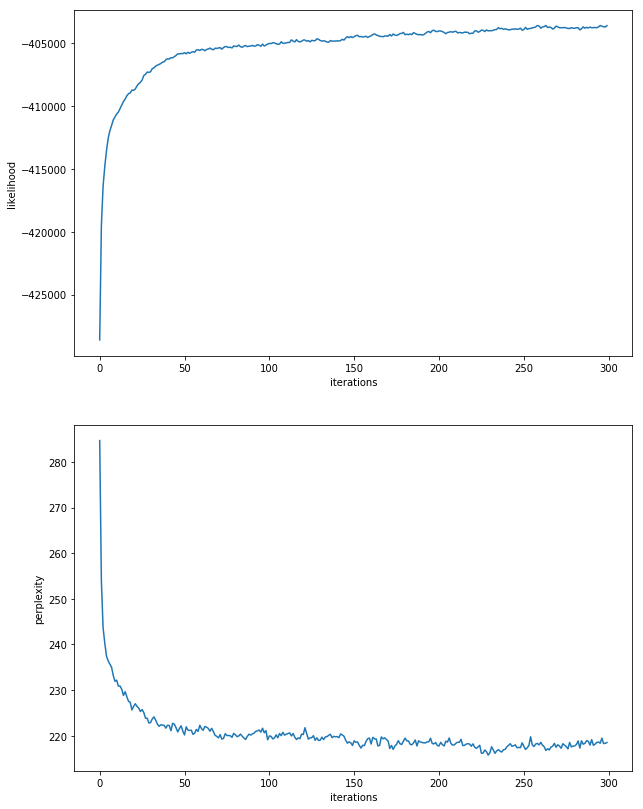

In [0]:
#尤度とperplexityのグラフ

figsize(10, 14)
plt.subplot(211)
plt.plot(L_list)
plt.xlabel("iterations")
plt.ylabel("likelihood")

plt.subplot(212)
plt.plot(perp_list)
plt.xlabel("iterations")
plt.ylabel("perplexity")
    
plt.savefig("HDP_LDA.png")

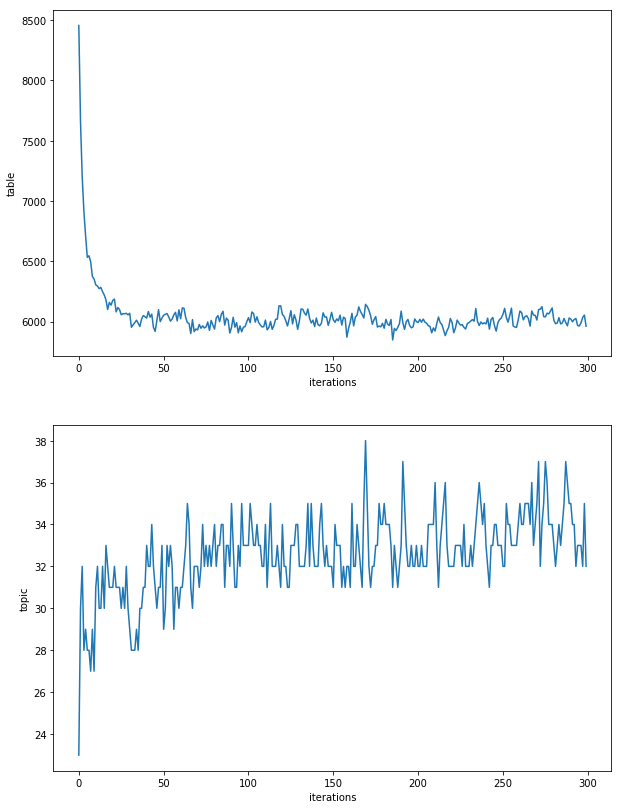

In [0]:
#階層ディリクレ過程におけるテーブルの数とトピック数

figsize(10, 14)
plt.subplot(211)
plt.plot(tablenum_list)
plt.xlabel("iterations")
plt.ylabel("table")

plt.subplot(212)
plt.plot(topicnum_list)
plt.xlabel("iterations")
plt.ylabel("topic")
    
plt.savefig("HDP_LDA_topic.png")

In [0]:
#各トピックである確率が一番大きい記事

sorted_theta4 = np.argsort(theta4, axis=0)
kizis_list = list(kizis.keys())
for i in range(theta4.shape[1]):
    print("topic%d %s" %(i, kizis_list[sorted_theta4[:, i][-1]]))

topic0 魔法少女アニメ
topic1 組み込みシステム
topic2 科学哲学
topic3 物理単位
topic4 逆元
topic5 メディア王国
topic6 舒明天皇
topic7 若狭国
topic8 都市国家
topic9 波
topic10 中野区
topic11 公用語
topic12 武蔵境駅
topic13 アングロアラブ
topic14 ミリタリーミニチュアシリーズ
topic15 核融合反応
topic16 教育課程
topic17 100
topic18 ユーフォニアム
topic19 フリーソフトウェア運動
topic20 能登空港
topic21 スーパーカミオカンデ
topic22 木村守男
topic23 電話
topic24 真核生物
topic25 記憶
topic26 フランス料理
topic27 普通乗車券
topic28 一分銀
topic29 カチンコ
topic30 経済
topic31 番勝負


## 最尤推定

EMアルゴリズムで対数尤度
$$L = \sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\log\sum^{K}_{k=1}\theta_{dk}\phi_{k\omega_{dn}}$$
を最大にするパラメータ$\Theta$, $\Phi$を求める。

イェンゼンの不等式より

$$
L = \sum^{D}_{d=1}\sum^{N_{d}}_{n=1}log\sum^{K}_{k=1}q_{dnk}\frac{\theta_{dk}\phi_{k\omega_{dn}}}{q_{dnk}}\geq\sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\sum^{K}_{k=1}q_{dnk}\log\theta_{dk}\phi_{k\omega_{dn}}-\sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\sum^{K}_{k=1}q_{dnk}\log{q_{dnk}}\equiv F
$$

となるので、下限$F$を最大にしていく処理を繰り返すことにより推定が行える。

$q_{dnk}$の更新式は、ラグランジュの未定乗数法より

$$F(q_{dnk}) = q_{dnk}log\theta_{dk}\phi_{k\omega_{dn}} - q_{dnk}\log q_{dnk} - \lambda(\sum^{K}_{k=1}q_{dnk} - 1) $$
$$\frac{\partial F(q_{dnk})}{\partial q_{dnk}} = \log\theta_{dk}\phi_{k\omega_{dn}} - \log q_{dnk} - 1 - \lambda = 0 $$
$$q_{dnk} = \exp(-\lambda - 1)\theta_{dk}\phi_{k\omega_{dn}} \;\;\; (1)$$

両辺をk=1からKまで足し合わせると
$$1 = \exp(-\lambda - 1)\sum^{K}_{k=1}\theta_{dk}\phi_{k\omega_{dn}}$$
$$\exp(-\lambda - 1) = \frac{1}{\sum^{K}_{k=1}\theta_{dk}\phi_{k\omega_{dn}}}$$
(1)に代入すると
$$q_{dnk} = \frac{\theta_{dk}\phi_{k\omega_{dn}}}{\sum^{K}_{k^{\prime} =1}\theta_{dk^{\prime}}\phi_{k^{\prime} \omega_{dn}}}$$

同様にして、$\Theta$の更新式は、

$$
\begin{align}
\frac{\partial F(\theta_{dk})}{\partial \theta_{dk}} &= \frac{\sum^{N_{d}}_{n=1}q_{dnk}}{\theta_{dk}} - \lambda = 0 \\
\theta_{dk}\lambda &= \sum^{N_{d}}_{n=1}q_{dnk} \;\;\; (2)
\end{align}$$

両辺をk=1からKまで足し合わせると

$$\lambda = \sum^{K}_{k=1}\sum^{N_{d}}_{n=1}q_{dnk}$$

よって(2)に代入して整理すると

$$\theta_{dk} = \frac{\sum^{N_{d}}_{n=1}q_{dnk}}{\sum^{K}_{k^{\prime}=1}\sum^{N_{d}}_{n=1}q_{dnk^{\prime}}}$$

$\Phi$の更新式は、

$$\frac{\partial F(\phi_{kv})}{\partial \phi_{kv}} = \frac{\sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk}}{\phi_{kv}} - \lambda = 0$$
$$\phi_{kv}\lambda = \sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk} \;\;\; (3)$$

両辺をv=1からVまで足し合わせると

$$\lambda = \sum^{V}_{v=1}\sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk}$$

よって(3)に代入して整理すると

$$\phi_{kv} = \frac{\sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk}}{\sum^{V}_{v^{\prime}=1}\sum^{D}_{d=1}\sum_{n:w_{dn}=v^{\prime}}q_{dnk}}$$

## 変分ベイズ推定
対数周辺尤度

$$\log p(W|\boldsymbol{\alpha}, \boldsymbol{\beta}) = \log \iint\sum_{Z}p(W, Z, \Theta, \Phi | \boldsymbol{\alpha}, \boldsymbol{\beta})d\Theta d\Phi$$

イェンゼンの不等式より

$$
\begin{align}
F &= \iint\sum_{Z}q(Z, \Theta, \Phi) \log\frac{p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta})}{q(Z, \Theta, \Phi)}d\Theta d\Phi \\
&= \iint\sum_{Z}q(Z)q(\Theta, \Phi)\bigl(\log p(Z|\Theta)p(\Theta|\boldsymbol{\alpha})p(W|Z,\Phi)p(\Phi|\boldsymbol{\beta}) - \log q(Z)q(\Theta, \Phi)\bigr)d\Theta d\Phi
\end{align}$$

対数周辺尤度と変分下限Fの差は、

$$\begin{align}
\log p(W|\boldsymbol{\alpha}, \boldsymbol{\beta}) - F &= \iint\sum_{Z}q(Z,\Theta, \Phi)\log p(W|\boldsymbol{\alpha}, \boldsymbol{\beta})d\Theta d\Phi - \iint\sum_{Z}q(Z, \Theta, \Phi) \log\frac{p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta})}{q(Z, \Theta, \Phi)}d\Theta d\Phi \\
&= \iint\sum_{Z}q(Z,\Theta, \Phi)\log\frac{q(Z,\Theta, \Phi)}{p(Z, \Theta, \Phi |W,\boldsymbol{\alpha}, \boldsymbol{\beta})}d\Theta d\Phi \\
&= KL\bigl(q(Z,\Theta, \Phi),p(Z, \Theta, \Phi |W,\boldsymbol{\alpha}, \boldsymbol{\beta})\bigr)
\end{align}$$

より、変分下限を最大にする$q(Z,\Theta, \Phi)$は真の事後分布$p(Z, \Theta, \Phi |W, \boldsymbol{\alpha}, \boldsymbol{\beta})$とのKLダイバージェンスを最小にする。

ここで$q(Z,\Theta, \Phi) = q(Z)q(\Theta, \Phi)$と分解できると仮定する。

変分事後分布$q(Z)$の推定を考える。

$$F(q(Z)) = \iint\sum_{Z}q(Z)q(\Theta, \Phi) \bigl(\log p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta}) - \log q(Z) - log q(\Theta, \Phi)\bigr)d\Theta d\Phi$$

$$\begin{align}
\frac{\partial F(q(Z))}{\partial q(Z)} &= \iint q(\Theta, \Phi) \bigl(\log p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta}) - \log q(Z) - log q(\Theta, \Phi) - 1 \bigr)d\Theta d\Phi \\
&= E_{q(\Theta, \Phi)}[\log p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta})] - \log q(Z) + const \;\;\; (1)
\end{align}$$

ここで$E_{q(x)}[f(x)] = \int q(x)f(x)dx$ は分布$q(x)$を用いた場合の$f(x)$の期待値を表す。

(1)を0にする$q(Z)$を解くと、

$$q(Z) \propto \exp(E_{q(\Theta, \Phi)}[\log p(W, Z, \Theta, \Phi | \boldsymbol{\alpha}, \boldsymbol{\beta})])$$

同様にして、

$$\frac{\partial F(q(\Theta, \Phi))}{\partial q(\Theta, \Phi)} = 0$$
より
$$q(\Theta, \Phi) \propto \exp(E_{q(Z)}[\log p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta})])$$

$$p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta}) = p(Z|\Theta)p(\Theta|\boldsymbol{\alpha})p(W|Z,\Phi)p(\Phi|\boldsymbol{\beta})$$

と分解でき、$\log p(\Theta|\boldsymbol{\alpha})$と$\log p(\Phi|\boldsymbol{\beta})$は$q(Z)$に関係しないので定数とみなせるので

$$\begin{align}
q(\Theta, \Phi) &\propto \exp \bigl(E_{q(Z)}[\log p(Z|\Theta)p(\Theta|\boldsymbol{\alpha})p(W|Z,\Phi)p(\Phi|\boldsymbol{\beta})]\bigr) \\
&= \exp \bigl(E_{q(Z)}[\log p(Z|\Theta)] + \log p(\Theta|\boldsymbol{\alpha}) \bigr) * \exp \bigl(E_{q(Z)}[\log p(W|Z,\Phi)] + \log p(\boldsymbol{\beta}) \bigr)
\end{align}$$

よって、パラメータの変分事後分布は

$$q(\Theta, \Phi) = q(\Theta)q(\Phi)$$

と分解できる。

$$\begin{align}
q(\theta_{d\cdot}) &\propto \exp\bigl(E_{q(z_{d\cdot})}[\log p(z_{d\cdot}|\theta_{d\cdot})] + \log p(\theta_{d\cdot}|\alpha_{d\cdot}) \bigr)\\
&= \exp\Bigl(E_{q(z_{d\cdot})}[\sum^{N_{d}}_{n=1}\log\theta_{dz_{n}}] + \log\frac{\Gamma(\sum^{K}_{k=1}\alpha_{dk})}{\prod^{K}_{k=1}\Gamma(\alpha_{dk})} + (maybe) \sum^{K}_{k=1}\log\theta^{\alpha_{dk}-1}_{dk}\Bigr)\\
&\propto \prod^{K}_{k=1}\theta^{\alpha_{dk}+\sum^{N_{d}}_{n=1}q_{d_{n}k}-1}_{dk}\\
&\propto Dirichlet(\theta_{d\cdot}|\alpha_{d1},\cdots, \alpha_{dk})
\end{align}$$

2段目では、$p(z_{d\cdot}|\theta_{d\cdot}) = \prod^{N_{d}}_{n=1}\theta_{dz_{n}}$であること、トピック分布$\theta_{d\cdot}$の事前分布がディリクレ分布であることを使用。
3段目では、$q_{d_{n}k}\equiv q(z_{d_{n}} = k)$を文書dのn番目の単語のトピック$z_{d_{n}}$が$k$になる変分事後分布とした時、$E_{q(z_{d\cdot})}[\sum^{N_{d}}_{n=1}\log\theta_{dz_{d_{n}}}] = \sum^{N_{d}}_{n=1}\sum^{K}_{k=1}q_{d_{n}k}\log\theta_{dk}$となる事、$\frac{\Gamma(\sum^{K}_{k=1}\alpha_{dk})}{\prod^{K}_{k=1}\Gamma(\alpha_{dk})}$は正規化項なので$\theta_{d\cdot}$に依存しないことを使用。

よって、$\theta_{1\cdot},\cdots,\theta_{D\cdot}$は独立であるので、

$$q(\Theta) = q(\theta_{1\cdot},\cdots,\theta_{D\cdot}) = \prod^{D}_{d=1}Dirichlet(\theta_{d\cdot}|\alpha_{d1},\cdots, \alpha_{dk})$$

が得られます。

また、$\alpha_{dk}$はディリクレ分布である変分事後分布$q(\theta_{d})$のパラメータ

$$\alpha_{dk} = \alpha_{dk} + \sum^{N_{d}}_{n=1}q_{d_{n}k}$$

となります。

同様の議論で単語分布の変分事後分布$q(\Phi)$は、

$$\begin{align}
q(\Phi) &\propto \exp \bigl(E_{q(Z)}[\log p(W|Z,\Phi)] + \log p(\Phi|\beta) \bigr)\\
&= \exp\Bigl(E_{q(Z)}[\sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\log\phi_{z_{dn}w_{dn}}] + \sum^{K}_{k=1}\log\frac{\Gamma(\sum^{V}_{v=1}\beta_{kv})}{\prod^{V}_{v=1}\Gamma(\beta_{kv})} + \sum^{K}_{k=1}\sum^{V}_{v=1}\log\phi^{\beta_{kv}-1}_{kv}\Bigr)\\
&= \exp\Bigl(\sum^{K}_{k=1}\sum^{V}_{v=1}\sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk}\log\phi_{kv} + \sum^{K}_{k=1}\log\frac{\Gamma(\sum^{V}_{v=1}\beta_{kv})}{\prod^{V}_{v=1}\Gamma(\beta_{kv})} + \sum^{K}_{k=1}\sum^{V}_{v=1}\log\phi^{\beta_{kv}-1}_{kv} \Bigr)\\
&\propto \exp\Bigl(\sum^{K}_{k=1}\sum^{V}_{v=1}\log\phi^{\beta_{kv} + \sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk} -1}_{kv} \Bigr)\\
&\propto \prod^{K}_{k=1}Dirichlet(\phi_{k}|\beta_{k1},\cdots,\beta_{KV})
\end{align}$$

となる。$\sum_{n:w_{dn}=v}$は、文書dで単語vが出てくる全てのnについての和を表す。
また、$\beta_{kv}$は、

$$\beta_{kv} = \beta_{kv} + \sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk}$$

となる。

トピック分布の変分事後分布は、

$$\begin{align}
p(Z) &\propto \exp\bigl(E_{q(\Theta,\Phi)}[\log p(Z|\Theta)p(\Theta|\alpha)p(W|Z,\Phi)p(\Phi|\beta)]\bigr)\\
&\propto \exp\bigl(E_{q(\Theta)}[\log p(Z|\Theta)] + E_{q(\Phi)}[\log p(W|Z,\Phi)]\bigr)\\
&= \exp\bigl(E_{q(\Theta)}[\sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\log \theta_{dz_{dn}}] + E_{q(\Phi)}[\sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\log\phi_{z_{dn}w_{dn}}]\bigr)\\
&= \prod^{D}_{d=1}\prod^{N_{d}}_{n=1}\exp\Bigl(\Psi(\alpha_{dz_{dn}}) - \Psi\bigl(\sum^K_{k=1}\alpha_{dk}\bigr) + \Psi(\beta_{z_{dn}w_{dn}}) - \Psi\bigl(\sum^{V}_{v=1}\beta_{z_{dn}v}\bigr)\Bigr) \;\;\;\;\; (1)
\end{align}$$

となる。2段目は、$Z$に関係ない定数部分を省略した。4段目では、ディリクレ分布に従う変数の対数の期待値

$$\int p(\phi|\boldsymbol{\beta})\log\phi_{v}d\phi = \Psi(\beta_{v}) - \Psi(\hat{\beta})$$

を用いた。ただし、$\Psi(x)$はディガンマ関数であり

$$\Psi(x) = \frac{d\log\Gamma(x)}{dx}\\
\hat{\beta} = \sum^{V}_{v=1}\beta_{v}$$

である。

(1)から、文書dのn番目の単語のトピックが$z_{d_{n}}$である確率が、

$$\exp\Bigl(\Psi(\alpha_{dz_{dn}}) - \Psi\bigl(\sum^K_{k=1}\alpha_{dk}\bigr) + \Psi(\beta_{z_{dn}w_{d_{n}}}) - \Psi\bigl(\sum^{V}_{v=1}\beta_{z_{dn}v}\bigr)\Bigr)$$

に比例することから、文書dのn番目の単語のトピックがkである確率$q_{dnk}$は、

$$q_{dnk} \propto \exp\Bigl(\Psi(\alpha_{dk}) - \Psi\bigl(\sum^K_{k^{\prime}=1}\alpha_{dk^{\prime}}\bigr) + \Psi(\beta_{kw_{dn}}) - \Psi\bigl(\sum^{V}_{v=1}\beta_{kv}\bigr)\Bigr)$$

と表されることが分かる。

## 崩壊型ギブスサンプリング
トピックモデルには未知変数が、$Z,\Theta,\Phi$が存在するがその内のパラメータ$\Theta,\Phi$を積分消去し、トピック集合の事後分布$p(Z|W,\alpha,\beta)$を推定する。
積分消去することで、サンプリングする必要のある変数の数を減らすことができる。
パラメータ$\Theta,\Phi$を積分消去した文書集合$W$とトピック集合$Z$の同時分布は、

$$p(W,Z|\alpha,\beta) = p(Z|\alpha)p(W|Z,\beta)$$

となる。
一つ目の因子は、

$$\begin{align}
p(Z|\alpha) &= \int p(Z|\Theta)p(\Theta|\alpha)d\Theta\\
&= \int \prod^{D}_{d=1}\prod^{K}_{k=1}\theta^{N_{dk}}_{dk}\prod^{D}_{d=1}\frac{\Gamma(\alpha K)}{\Gamma(\alpha)^{K}}\prod^{K}_{k=1}\theta^{\alpha - 1}_{dk}d\Theta\\
&= \int \prod^{D}_{d=1}\frac{\Gamma(\alpha K)}{\Gamma(\alpha)^{K}}\prod^{K}_{k=1}\theta^{\alpha + N_{dk} - 1}_{dk}d\Theta\\
&= \frac{\Gamma(\alpha K)^{D}}{\Gamma(\alpha)^{KD}}\prod^{D}_{d=1}\frac{\prod^{K}_{k=1}\Gamma(N_{dk} + \alpha)}{\Gamma(N_{d} + \alpha K)} \;\;\;\;\; (1)
\end{align}$$

二つ目の因子は、

$$\begin{align}
p(W|Z,\beta) &= \int p(W|Z,\Phi)p(\Phi|\beta)d\Phi\\
&= \int\prod^{K}_{k=1}\prod^{V}_{v=1}\phi^{N_{kv}}_{kv}\prod^{K}_{k=1}\frac{\Gamma(\beta V)}{\Gamma(\beta)^{V}}\prod^{V}_{v=1}\phi^{\beta-1}_{kv}\\
&= \frac{\Gamma(\beta V)^{K}}{\Gamma(\beta)^{VK}}\prod^{K}_{k=1}\frac{\prod^{V}_{v=1}\Gamma(N_{kv} + \beta)}{\Gamma(N_{k} + \beta V)} \;\;\;\;\; (2)
\end{align}$$

となる。$N_{kv}$はトピックkに割り当てられた単語vの単語数、$N_{k}$は、$N_{k} = \sum^{V}_{v=1}N_{kv}$である。
また、ディリクレ分布の正規化項の計算

$$\int\prod^{V}_{v=1}\phi^{\beta_{v}-1}_{v}d\phi = \frac{\prod^{V}_{v=1}\Gamma(\beta_{v})}{\Gamma(\sum^{V}_{v=1}\beta_{v})}$$

を使用している。

$z_{d_{N}}$のサンプリング式は、$z_{d_{N}}$を除いたサンプリング集合$Z_{\backslash d_{N}}$と文書集合Wが与えられた時の$z_{d_{N}}$の条件付き確率

$$\begin{align}
&p(z_{dn} = k|W,Z_{\backslash dn},\alpha,\beta) \\
&= \frac{p(z_{dn} = k,Z_{\backslash dn},w_{dn},W_{\backslash dn}|\alpha,\beta)}{p(Z_{\backslash dn},W|\alpha,\beta)}\\
&\propto p(z_{dn} = k,Z_{\backslash dn},w_{dn},W_{\backslash dn}|\alpha,\beta)\\
&= p(w_{dn}|z_{dn} = k,Z_{\backslash dn},W_{\backslash dn},\alpha,\beta)p(W_{\backslash dn}|z_{dn} = k,Z_{\backslash dn},\alpha,\beta)p(z_{dn} = k|Z_{\backslash dn},\alpha,\beta)p(Z_{\backslash dn}|\alpha,\beta)\\
&\propto p(z_{dn} = k|Z_{\backslash dn},\alpha)p(w_{dn}|W_{\backslash dn},z_{dn} = k,Z_{\backslash dn},\beta)
\end{align}$$

2段目の分母は、$z_{dn} = k$に関係しない項なので省略、4段目の2つ目の因子は、$W_{\backslash dn}$の確率は$z_{dn} = k$を与えても無情報なので$p(W_{\backslash dn}|Z_{\backslash dn},\alpha,\beta)$となり、これは$z_{dn} = k$に無関係なので省略、4つ目の因子も無関係なので省略。5段目の1つ目の因子の$\beta$並びに2つ目の因子の$\beta$はそれぞれ無関係なので省略した。

1つ目の因子は、(1)と$\Gamma(x) = (x-1)\Gamma(x-1)$を用いて、

$$\begin{align}
p(z_{dn} = k|Z_{\backslash dn},\alpha) &= \frac{p(z_{dn} = k,Z_{\backslash dn}|\alpha)}{p(Z_{\backslash dn}|\alpha)}\\
&= \frac{\frac{\Gamma(N_{dk\backslash dn}+1+\alpha)\prod_{k^{\prime}\neq k}\Gamma(N_{dk^{\prime}\backslash dn}+\alpha)}{\Gamma(N_{d}+\alpha K)}}{\frac{\prod^{K}_{k^{\prime} = 1}\Gamma(N_{dk^{\prime}\backslash dn}+\alpha)}{\Gamma(N_{d}-1+\alpha K)}}\\
&= \frac{\frac{(N_{dk\backslash dn}+\alpha)\prod^{K}_{k^{\prime}=1}\Gamma(N_{dk^{\prime}\backslash dn}+\alpha)}{(N_{d}-1+\alpha K)\Gamma(N_{d}-1+\alpha K)}}{\frac{\prod^{K}_{k^{\prime} = 1}\Gamma(N_{dk^{\prime}\backslash dn}+\alpha)}{\Gamma(N_{d}-1+\alpha K)}}\\
&= \frac{N_{dk\backslash dn} + \alpha}{N_{d}-1+\alpha K}
\end{align}$$

と計算できる。ここで$N_{dk^{\prime}\backslash dn}$とは、n番目の単語を除いた時の文書dでトピックkが割り当てられた単語数を表す。2段目では、(1)の$\frac{\Gamma(\alpha K)^{D}}{\Gamma(\alpha)^{KD}}$は分母分子で共通なので約分、$\prod^{D}_{d=1}$の部分は、文書dでの確率を議論している為、文書d以外は分母分子共通で約分できる。

2つ目の因子は(2)を用いて
$$\begin{align}
p(w_{dn}|W_{\backslash dn},z_{dn} = k, Z_{\backslash dn},\beta) &= \frac{p(w_{dn},W_{\backslash dn}|z_{dn} = k, Z_{\backslash dn},\beta)}{p(W_{\backslash dn}|Z_{\backslash dn},\beta)}\\
&= \frac{\frac{\Gamma(N_{kw_{dn}\backslash dn}+1+\beta)\prod_{w\neq w_{dn}}\Gamma(N_{kv\backslash dn}+\beta)}{\Gamma(N_{k\backslash dn}+1+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(N_{kv\backslash dn}+\beta)}{\Gamma(N_{k\backslash dn}+\beta V)}}\\
&= \frac{N_{kw_{dn}\backslash dn} + \beta}{N_{k\backslash dn} + \beta V}
\end{align}$$

これらを用いると、

$$p(z_{dn} = k|W,Z_{\backslash dn},\alpha,\beta) \propto (N_{dk\backslash dn} + \alpha)\frac{N_{kw_{dn}\backslash dn} + \beta}{N_{k\backslash dn} + \beta V}$$

が得られる。
ハイパーパラメータ$\alpha,\beta$は、(1)(2)をそれぞれ最大化する事により推定できるので、不動点反復法を用いると、

$$
\alpha^{new} = \alpha\frac{\sum^{D}_{d=1}\sum^{K}_{k=1}\Psi(N_{dk}+\alpha) - DK\Psi(\alpha)}{K\sum^{D}_{d=1}\Psi(N_{d}+\alpha K) - DK\Psi(\alpha K)}\\
\beta^{new} = \beta\frac{\sum^{K}_{k=1}\sum^{V}_{v=1}\Psi(N_{kv} + \beta) - KV\Psi(\beta)}{V\sum^{K}_{k=1}\Psi(N_{k} + \beta V) - KV\Psi(\beta V)}
$$

初期値は、割り当てられているところまでを使用して計算すれば良い。

積分消去したトピック分布$\Theta$と単語分布$\Phi$は予測確率として

$$\begin{align}
\theta_{dk} &= p(z_{dn_{new}} = k|Z,\alpha)\\
&= \frac{N_{dk} + \alpha}{N_{d} + \alpha K}\\
\phi_{kv} &= p(w_{dn_{new}}|W,z_{dn_{new}} = k, Z,\beta)\\
&= \frac{N_{kv} + \beta}{N_{k} + \beta V}
\end{align}$$

と(点)推定できる。

これまでは、ディリクレ分布のパラメータが全て一様な場合を考えてきたが、一様でない場合$\theta_{d} \sim Dirichlet(\alpha_{1},\cdots,\alpha_{K}), \phi_{k} \sim Dirichlet(\beta_{1},\cdots,\beta_{V})$も考えられる。
その場合のサンプリング確率とハイパーパラメータの更新式は、

$$\begin{align}
&p(z_{dn} = k|W,Z_{\backslash dn},\alpha,\beta) \propto (N_{dk\backslash dn} + \alpha_{k})\frac{N_{kw_{dn}\backslash dn} + \beta_{w_{dn}}}{N_{k\backslash dn} + \sum^{V}_{v=1}\beta_{v}}\\
&\alpha^{new}_{k} = \alpha_{k}\frac{\sum^{D}_{d=1}\Psi(N_{dk}+\alpha_{k}) - D\Psi(\alpha_{k})}{\sum^{D}_{d=1}\Psi(N_{d}+\sum^{K}_{k^{\prime}=1}\alpha_{k^{\prime}}) - DK\Psi(\sum^{K}_{k^{\prime}=1}\alpha_{k^{\prime}})}\\
&\beta^{new}_{v} = \beta_{v}\frac{\sum^{K}_{k=1}\Psi(N_{kv} + \beta_{v}) - K\Psi(\beta_{v})}{\sum^{K}_{k=1}\Psi(N_{k} + \sum^{V}_{v^{\prime=1}}\beta_{v^{\prime}}) - K\Psi(\sum^{V}_{v^{\prime=1}}\beta_{v^{\prime}})}
\end{align}$$

となる。
ただし、トピック分布のハイパーパラメータは一様でなく、単語分布のハイパーパラメータは一様である場合に性能が良いことが実験で確認されている。

## HDP-LDA

#### 中華料理店過程
無限次元の混合比と無限個の要素モデルを考える際、中華料理店過程を用いると有限個の混合比と要素モデルを扱うだけで推定が可能になる。
中華料理店過程では、ある要素においてその要素がテーブルtに割り当てられる確率が

$$
p(x_{d} = t|x_{1},\cdots,x_{d-1},\alpha)=\left\{
\begin{array}{ll}
\frac{D_{t}}{d-1+\alpha} & (既存テーブル)\\
\frac{\alpha}{d-1+\alpha} & (新テーブル)
\end{array}
\right.
$$

と表される。ここで$D_{t}$はテーブル$t$に割り当てられた要素数、$\alpha$は集中パラメータである。新しいテーブルが割り当てられる確率は集中パラメータに比例する。
中華料理店過程は交換可能性より要素がテーブルに着く際にどんな順番であっても確率は変わらないので、サンプリングしたい要素が一番最後にテーブルに着くと考えて良い。よって、$x_{\backslash d} = (x_{1},\cdots,x_{d-1},x_{d+1},\cdots,x_{D})$が与えられた時の$x_{d}$の条件付き確率となるので、

$$
p(x_{d} = t|x_{\backslash d},\alpha)=\left\{
\begin{array}{ll}
\frac{D_{t\backslash d}}{D-1+\alpha} & (既存テーブル)\\
\frac{\alpha}{D-1+\alpha} & (新テーブル)
\end{array}
\right.
$$

となる。$D_{t\backslash d}$はテーブルtの人数から$x_{d}$を除いたものである。

### 階層ディリクレ過程
トピック分布は文書ごとにトピック分布を持っている。なので各文書にディリクレ過程を用いれば各文書のトピック分布が推定できる。しかしそれでは文書間でトピックが共有されていないので意味を為さない。そこで、ディリクレ過程を重ねる階層ディリクレ過程を使用する。

文書ごとのディリクレ過程

$$G_{d} \sim DP(\alpha,H) \;\;\;\; d = 1,\cdots,D$$

は共有の基底分布Hを持ち、その基底分布はディリクレ過程

$$H \sim DP(\gamma, H_{0})$$

から生成されたものと仮定する。このようにすることで、ディリクレ過程によって生成された分布$H$は離散分布である為、文書ごとのディリクレ過程から生成される分布$G_{d}$は、他の文書と共有することができる。

トピック分布の場合、$H_{0} = Dilichlet(\beta)$である。

#### 中華料理店フランチャイズ
階層ディリクレ過程を使用すると文書全体のトピック数および文書ごとのトピック数が推定できる。
階層ディリクレ過程は中華料理店フランチャイズで構成できる。

中華料理店フランチャイズでは、客(単語)は入店した際にテーブルを選び、それが新しいテーブルであるならメニュー(トピック)を選ぶ。どのテーブルを選ぶかは、テーブルに座っている人数に比例し、どのメニューを選ぶかは、そのメニューを選んでいるテーブル数に比例する。

中華料理店フランチャイズを仮定したトピックモデルは、崩壊型ギブスサンプリングを用いることによりトピック数を事前に決める必要なく推定できる。
具体的には、単語ごとのテーブルとテーブルごとのトピックの割当をサンプリングする。

文書dのn番目の単語がテーブルlを選ぶ確率を求める。この際、選び方は、(1)既存のテーブルに座る(2)新テーブルで既存トピック(3)新テーブルで新トピックの３通りが考えられる。

テーブルのサンプリング確率は、

$$\begin{align}
p(t_{dn} = l|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) &=\left\{
\begin{array}{ll}
p(t_{dn} = l_{used}|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) & (既存テーブル)\\
p(t_{dn} = l_{new}|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) & (新テーブル)
\end{array}
\right.\\
\\
&=\left\{
\begin{array}{ll}
p(t_{dn} = l_{used}|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) & (1)\\
p(t_{dn} = l_{new}, z_{dl} = k_{used}|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) & (2)\\
p(t_{dn} = l_{new}, z_{dl} = k_{new}|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) & (3)
\end{array}
\right.
\end{align}$$

となる。ここで、Tは単語に割り当てられたテーブル集合、Zはテーブルに割り当てられたトピック集合、$\alpha$は文書毎のディリクレ過程の集中パラメータ、$\gamma$は文書集合全体のディリクレ過程の集中パラメータ、$\beta$はトピックごとの単語分布のハイパーパラメータである。崩壊型ギブスサンプリングでの$p(z_{dn} = k|Z_{\backslash dn},\alpha)p(w_{dn}|W_{\backslash dn},z_{dn} = k,Z_{\backslash dn},\beta)$の変形を参考に参考にすると

$$\begin{align}
&p(t_{dn} = l|W,T_{\backslash dn},Z,\alpha,\gamma,\beta)\\
&\propto \left\{
\begin{array}{ll}
p(t_{dn} = l_{used}|T_{\backslash dn},Z,\alpha)p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{used},Z,\beta) & (1^{\prime})\\
p(t_{dn} = l_{new}, z_{dl} = k_{used}|T_{\backslash dn},Z,\alpha,\gamma)p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{new},z_{dl} = k_{used},Z,\beta) & (2^{\prime})\\
p(t_{dn} = l_{new}, z_{dl} = k_{new}|T_{\backslash dn},Z,\alpha,\gamma)p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{new},z_{dl} = k_{new},Z,\beta) & (3^{\prime})
\end{array}
\right.
\end{align}$$

となる。
さらにそれぞれの式を変形していくと、

$(1^{\prime})$の1つ目の因子は、中華料理店過程なので、
$$p(t_{dn} = l_{used}|T_{\backslash dn},Z,\alpha) \propto N_{dl\backslash dn}$$

2つ目の因子は、$\Gamma(x) = (x-1)\Gamma(x-1)$を用いて、周辺化の式、

$$p(W|Z,\beta) = \frac{\Gamma(\beta V)^{K}}{\Gamma(\beta)^{VK}}\prod^{K}_{k=1}\frac{\prod^{V}_{v=1}\Gamma(N_{kv} + \beta)}{\Gamma(N_{k} + \beta V)}$$

を思い出すと、

$$\begin{align}
p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{used},Z,\beta) &= \frac{p(w_{dn}, W_{\backslash dn}|T_{\backslash dn}, t_{dn} = l_{used},Z,\beta)}{p(W_{\backslash dn}|T_{\backslash dn},Z,\beta)}\\
&= \frac{\frac{\Gamma(N_{z_{dl}w_{dn}\backslash dn}+1+\beta)\prod_{v\neq w_{dn}}\Gamma(N_{z_{dl}v\backslash dn}+\beta)}{\Gamma(N_{z_{dl}\backslash dn}+1+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(N_{z_{dl}v\backslash dn}+\beta)}{\Gamma(N_{z_{dl}\backslash dn}+\beta V)}}\\
&= \frac{N_{z_{dl}w_{dn}\backslash dn} + \beta}{N_{z_{dl}\backslash dn} + \beta V}
\end{align}$$

となる。ここで、$N_{dl}$は文書dのl番目のテーブルを選んだ単語数。

$(2^{\prime})$の1つ目の因子は、中華料理店過程なので、

$$\begin{align}
p(t_{dn} = l_{new}, z_{dl} = k_{used}|T_{\backslash dn},Z,\alpha,\gamma) &= p(t_{dn} = l_{new}|T_{\backslash dn},Z,\alpha)p(z_{dl} = k_{used}|T_{\backslash dn},Z,\gamma)\\
&\propto \alpha\frac{M_{k}}{M+\gamma}
\end{align}$$

ここで$M_{k}$は、トピックkを選んだテーブル数、$M$は、総テーブル数を表す。

2つ目の因子は、$\Gamma(x) = (x-1)\Gamma(x-1)$を用いると、

$$\begin{align}
p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{new},z_{dl} = k_{used},Z,\beta) &= \frac{p(w_{dn}, W_{\backslash dn}|T_{\backslash dn}, t_{dn} = l_{new},Z,z_{dl=k_{used}},\beta)}{p(W_{\backslash dn}|T_{\backslash dn},Z,\beta)}\\
&= \frac{\frac{\Gamma(N_{kw_{dn}\backslash dn}+1+\beta)\prod_{v\neq w_{dn}}\Gamma(N_{kv\backslash dn}+\beta)}{\Gamma(N_{k\backslash dn}+1+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(N_{kv\backslash dn}+\beta)}{\Gamma(N_{k\backslash dn}+\beta V)}}\\
&= \frac{N_{kw_{dn}\backslash dn} + \beta}{N_{k\backslash dn} + \beta V}
\end{align}$$

$(3^{\prime})$の1つ目の因子は、中華料理店過程なので、

$$\begin{align}
p(t_{dn} = l_{new}, z_{dl} = k_{new}|T_{\backslash dn},Z,\alpha,\gamma) &= p(t_{dn} = l_{new}|T_{\backslash dn},Z,\alpha)p(z_{dl} = k_{new}|T_{\backslash dn},Z,\gamma)\\
&\propto \alpha\frac{\gamma}{M + \gamma}
\end{align}$$

2つ目の因子は、

$$\begin{align}
p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{new},z_{dl} = k_{new},Z,\beta) &= \frac{p(w_{dn}, W_{\backslash dn}|T_{\backslash dn}, t_{dn} = l_{new},Z,z_{dl=k_{new}},\beta)}{p(W_{\backslash dn}|T_{\backslash dn},Z,\beta)}\\
&= \frac{\frac{\Gamma(1+\beta)\prod_{v\neq w_{dn}}\Gamma(\beta)}{\Gamma(1+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(\beta)}{\Gamma(\beta V)}}\\
&= \frac{\beta}{\beta V}\\
&= \frac{1}{V}
\end{align}$$

よって、

$$\begin{align}
&p(t_{dn} = l|W,T_{\backslash dn},Z,\alpha,\gamma,\beta)\\
&\propto \left\{
\begin{array}{ll}
N_{dl\backslash dn}\frac{N_{z_{dl}w_{dn}\backslash dn} + \beta}{N_{z_{dl}\backslash dn} + \beta V} & (1)\\
\alpha\frac{M_{k}}{M+\gamma}\frac{N_{kw_{dn}\backslash dn} + \beta}{N_{k\backslash dn} + \beta V} & (2)\\
\alpha\frac{\gamma}{M + \gamma}\frac{1}{V} & (3)
\end{array}
\right.
\end{align}$$

が導出される。

次に、テーブル毎のトピックのサンプリング確率を導出する。トピックの選び方は、(1)既存トピック(2)新しいトピックの2通りが考えられるので

文書dのl番目のテーブルがトピックkを選ぶ確率は、

$$\begin{align}
&p(z_{dl} = k|W,T,Z_{\backslash dl},\gamma,\beta)\\
&\propto \left\{
\begin{array}{ll}
p(z_{dl} = k_{used}|T,Z_{\backslash dl},\gamma)p(w_{dl}|W_{\backslash dl}, T, Z_{\backslash dl}, z_{dl} = k_{used}, \beta) & (1)\\
p(z_{dl} = k_{new}|T,Z_{\backslash dl},\gamma)p(w_{dl}|W_{\backslash dl}, T, Z_{\backslash dl}, z_{dl} = k_{new}, \beta) & (2)
\end{array}
\right.
\end{align}$$

となる。

$(1)$の1つ目の因子は、中華料理店過程なので、

$$p(z_{dl} = k_{used}|T,Z_{\backslash dl},\gamma) = M_{k\backslash dl}$$

2つ目の因子は、

$$\begin{align}
p(w_{dl}|W_{\backslash dl}, T, Z_{\backslash dl}, z_{dl} = k_{used}, \beta) &= \frac{p(w_{dl}, W_{\backslash dl}|T,Z_{\backslash dl}, z_{dl} = k_{used}, \beta)}{p(W_{\backslash dl}|T,Z_{\backslash dl},\beta)}\\
&= \frac{\frac{\prod^{V}_{v=1}\Gamma(N_{kv\backslash dl} + N_{klv} + \beta)}{\Gamma(N_{k\backslash dl} + N_{dl}+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(N_{kv\backslash dl}+\beta)}{\Gamma(N_{k\backslash dl}+\beta V)}}\\
&= \frac{\Gamma(N_{k\backslash dl}+\beta V)}{\Gamma(N_{k\backslash dl} + N_{dl}+\beta V)}\prod^{V}_{v=1}\frac{\Gamma(N_{kv\backslash dl} + N_{klv} + \beta)}{\Gamma(N_{kv\backslash dl}+\beta)}
\end{align}$$

となる。ここで、$N_{dlv}$は文書dのl番目のテーブルに割り当てられた単語vの単語数を表す。

同様にして$(2)$の1つ目の因子は、中華料理店過程なので、

$$p(z_{dl} = k_{new}|T,Z_{\backslash dl},\gamma) = \gamma$$

2つ目の因子は、

$$\begin{align}
p(w_{dl}|W_{\backslash dl}, T, Z_{\backslash dl}, z_{dl} = k_{new}, \beta) &= \frac{p(w_{dl}, W_{\backslash dl}|T,Z_{\backslash dl}, z_{dl} = k_{new}, \beta)}{p(W_{\backslash dl}|T,Z_{\backslash dl},\beta)}\\
&= \frac{\frac{\prod^{V}_{v=1}\Gamma(N_{klv} + \beta)}{\Gamma(N_{dl}+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(\beta)}{\Gamma(\beta V)}}\\
&= \frac{\Gamma(\beta V)}{\Gamma(N_{dl}+\beta V)}\frac{\prod^{V}_{v=1}\Gamma(N_{klv} + \beta)}{\Gamma(\beta)^{V}}
\end{align}$$

よって、

$$\begin{align}
&p(z_{dl} = k|W,T,Z_{\backslash dl},\gamma,\beta)\\
&\propto \left\{
\begin{array}{ll}
M_{k\backslash dl}\frac{\Gamma(N_{k\backslash dl}+\beta V)}{\Gamma(N_{k\backslash dl} + N_{dl}+\beta V)}\prod^{V}_{v=1}\frac{\Gamma(N_{kv\backslash dl} + N_{klv} + \beta)}{\Gamma(N_{kv\backslash dl}+\beta)} & (1)\\
\gamma\frac{\Gamma(\beta V)}{\Gamma(N_{dl}+\beta V)}\frac{\prod^{V}_{v=1}\Gamma(N_{klv} + \beta)}{\Gamma(\beta)^{V}} & (2)
\end{array}
\right.
\end{align}$$

これらの確率を使用して単語ごとのテーブル割当のサンプリングとテーブルごとのトピック割当のサンプリングを繰り返し行うことで、中華料理店フランチャイズに基づくトピックモデルを推定できる。

積分消去したトピック分布$\Theta$と単語分布$\Phi$は予測確率として

$$
\begin{align}
\theta_{dk} &= \left\{
\begin{array}{ll}
p(t_{dn_{new}} = l_{used}|T,Z,\alpha) + p(t_{dn_{new}} = l_{new}, z_{dl_{new}} = k_{used}|T,Z,\alpha,\gamma)& (既存トピック)\\
p(t_{dn_{new}} = l_{new}, z_{dl_{new}} = k_{new}|T,Z,\alpha,\gamma)& (新しいトピック)
\end{array}
\right.\\
&= \left\{
\begin{array}{ll}
\frac{1}{N_{d} + \alpha}(N_{dk} + \alpha\frac{M_{k}}{M + \gamma}) & (既存トピック)\\
\frac{1}{N_{d} + \alpha}\frac{\alpha\gamma}{M + \gamma} & (新しいトピック)
\end{array}
\right.\\
 \\
\phi_{kv} &= \left\{
\begin{array}{ll}
p(w_{dn_{new}} = v|W, T, t_{dn_{new}}=l_{used},Z,\beta) \;\;or\;\; p(w_{dn_{new}} = v|W, T, t_{dn_{new}}=l_{new},z_{dl_{new}} = k_{used},Z,\beta)& (既存トピック)\\
p(w_{dn_{new}} = v|W, T, t_{dn_{new}}=l_{new},z_{dl_{new}} = k_{new},Z,\beta)& (新しいトピック)
\end{array}
\right.\\
&= \left\{
\begin{array}{ll}
\frac{N_{kv} + \beta}{N_{k} + \beta V}& (既存トピック)\\
\frac{1}{V}& (新しいトピック)
\end{array}
\right.
\end{align}
$$

と(点)推定できる。
LDAでの崩壊型ギブスサンプリングとは少し異なり、HDP-LDAでは新トピックに割り振られる可能性があるので、予想確率でもそれを考慮した式になっている。
ただ、学習したデータを活用して何かを行う際は、LDAでの崩壊型ギブスサンプリングと同じ予想確率にした方が良い気がする。